In [1]:
import math
import json
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
# from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# %matplotlib inline
# %config InlineBackend. figure_format='retina'
# sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
# color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
# sns.set_palette(sns.color_palette(color_pal))
# rcParams['figure.figsize' ] = 14, 7
# rcParams['text.color'] = 'black'       # Titles and text
# rcParams['axes.labelcolor'] = 'white'  # Axis labels
# rcParams['xtick.color'] = 'black'      # X-axis tick labels
# rcParams['ytick.color'] = 'black'
# tqdm. pandas ()

# Light theme settings
sns.set(style='whitegrid', palette='muted', font_scale=1.2, 
        rc={
            "axes.facecolor": "#FAFAFA",   # Light grey background
            "axes.grid": True,
            "grid.color": "#DDDDDD",       # Light grid lines
            "axes.edgecolor": "#CCCCCC"    # Light axis edges
        })

# Light pastel color palette
color_pal = ["#FF3C00", "#0059FF", "#00FF0D", "#D900FF", "#C09300",]
sns.set_palette(sns.color_palette(color_pal))

# Set figure size and text colors appropriate for light background
rcParams['figure.figsize'] = (14, 7)
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'black'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'      # Y-axis tick labels

# Enable tqdm pandas integration
tqdm.pandas()

In [3]:
train_df_scaled = pd.read_csv("Alibaba_random_500/train.csv")
val_df_scaled = pd.read_csv("Alibaba_random_500/val.csv")
test_df_scaled = pd.read_csv("Alibaba_random_500/test.csv") 

In [4]:
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape # 16043024

((16043024, 13), (3437791, 13), (3437792, 13))

In [5]:
train_df_scaled=train_df_scaled[-(int)(len(train_df_scaled)/5):]
val_df_scaled=val_df_scaled[:(int)(len(test_df_scaled)/5)]
test_df_scaled=test_df_scaled[:(int)(len(test_df_scaled)/5)]
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape

((3208604, 13), (687558, 13), (687558, 13))

In [6]:
train_df_scaled.columns

Index(['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent'],
      dtype='object')

In [7]:
timesteps = 59 # Define timesteps: for nxn window choose 2n-1 
columns_to_scale = ['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent']

forecast_horizon = 30  # Number of future steps to predict

def create_sequences(data, timesteps, target_idx, horizon):
    X, y = [], []
    for i in tqdm(range(timesteps, len(data) - horizon + 1)):
        X.append(data[i - timesteps:i])
        y.append(data[i:i + horizon, target_idx])  # Get next 30 values
    return np.array(X), np.array(y)

cpu_data = train_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_train, y_train = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = val_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_val, y_val = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = test_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_test, y_test = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences


100%|██████████| 687470/687470 [00:00<00:00, 2346310.31it/s]


In [8]:
features = X_train.shape[2]
features

13

In [9]:
def visualize_target_sequence(X, y_true, y_pred=None, sample_idx=0, feature_idx=-1):
    """
    Visualizes the input sequence and forecast horizon for a selected sample.

    Args:
        X (np.ndarray): Input sequences of shape (samples, timesteps, features).
        y_true (np.ndarray): Ground truth targets of shape (samples, horizon).
        y_pred (np.ndarray, optional): Predicted targets of shape (samples, horizon). Default is None.
        sample_idx (int): Index of the sample to visualize.
        feature_idx (int): Index of the feature to plot from X (default: last feature).
    """
    input_sequence = X[sample_idx, :, feature_idx]
    future_targets = y_true[sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(input_sequence)), input_sequence, label='Input: cpu_difference (past)')
    plt.plot(range(len(input_sequence), len(input_sequence) + len(future_targets)),
             future_targets, label='Target: cpu_difference (future)', linestyle='--')

    if y_pred is not None:
        future_preds = y_pred[sample_idx]
        plt.plot(range(len(input_sequence), len(input_sequence) + len(future_preds)),
                 future_preds, label='Prediction: cpu_difference', linestyle='-.', color='red')

    plt.axvline(x=len(input_sequence)-1, color='gray', linestyle=':', label='Prediction Start')
    plt.xlabel('Timestep')
    plt.ylabel('cpu_difference')
    plt.title(f'cpu_difference Forecast (Sample #{sample_idx})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
# Prepare Data (Example: replace with actual dataset)
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

print(X_train.shape, y_train.shape)  # Should be (1000, timesteps, features) and (1000, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data

torch.Size([3208516, 59, 13]) torch.Size([3208516, 30])


In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### helpers

In [12]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [13]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
        return start_epoch
    return 0  # If no checkpoint, start from epoch 0

In [14]:
# Function to compute validation loss
def evaluate_model_trianing(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            # y_batch = y_batch.view(-1, 1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [15]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, checkpoint_interval=2, patience=5, path="checkpoints"):
    start_epoch = load_checkpoint(model, optimizer, path)
    model.train()
    print("#### TRAINING STARTED ####")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate_model_trianing(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, val_loss, path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1} (no improvement in val loss for {patience} epochs).")
            break

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, path)

    # Final stats
    total_time = round(time.time() - start_time, 2)
    print("\n#### TRAINING COMPLETE ####")
    print(f"Total Time Elapsed: {total_time} seconds")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")

    # Plotting Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# Function to load model from checkpoint
def load_model_from_checkpoint(model, checkpoint_path, device="cpu"):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint found! Using randomly initialized model.")
    return model

In [17]:
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

def evaluate_model(model, test_loader, checkpoint_path, device="cpu"):
    model = load_model_from_checkpoint(model, checkpoint_path, device)
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    total_inference_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            start_time = time.perf_counter()
            y_pred = model(X_batch)
            end_time = time.perf_counter()

            total_inference_time += (end_time - start_time)
            total_samples += X_batch.size(0)

            all_predictions.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Convert to NumPy
    predictions_np = np.concatenate(all_predictions, axis=0)
    y_test_np = np.concatenate(all_targets, axis=0)

    # Convert to Torch tensors for loss calculations
    predictions_tensor = torch.tensor(predictions_np, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32, device=device)

    if predictions_tensor.shape != y_test_tensor.shape:
        print(f"⚠️ Shape mismatch! Predictions: {predictions_tensor.shape}, Targets: {y_test_tensor.shape}")
        y_test_tensor = y_test_tensor.view_as(predictions_tensor)

    # Calculate metrics
    mae = mean_absolute_error(y_test_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
    huber_loss = nn.HuberLoss()(predictions_tensor, y_test_tensor).item()
    mse_loss = nn.MSELoss()(predictions_tensor, y_test_tensor).item()
    avg_inference_time = (total_inference_time / total_samples) * 1000  # ms per sample

    # Print metrics
    print("\n##### Evaluation Metrics #####")
    print(f"Test MAE         : {mae:.4f}")
    print(f"Test RMSE        : {rmse:.4f}")
    print(f"Test Huber Loss  : {huber_loss:.4f}")
    print(f"Test MSE Loss    : {mse_loss:.4f}")
    print(f"Avg Inference Time per Sample: {avg_inference_time:.4f} ms")
    print(f"Total Evaluation Time        : {total_inference_time:.2f} seconds")

    return predictions_np


In [18]:
def print_model_summary(model):
    total_params = 0
    print(f"{'Layer':<40} {'Param Shape':<30} {'# Params'}")
    print("-" * 80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")

    print("-" * 80)
    print(f"{'Total Trainable Params':<40} {'':<30} {total_params:,}")


#### proposed

In [ ]:
# class SE(nn.Module):
#     def __init__(self, in_channels, ratio):
#         super().__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),  # squeeze
#             nn.Conv2d(in_channels, in_channels//ratio, kernel_size=(1, 1)),  # compress
#             nn.ReLU(),
#             nn.Conv2d(in_channels//ratio, in_channels, kernel_size=(1, 1)),  # excitation
#             nn.Sigmoid(),
#         )

#     def forward(self, X):
#         return self.se(X)

# class SENet(nn.Module):
#     def __init__(self, in_channels, ratio):
#         super().__init__()
#         self.se = SE(in_channels, ratio)
#         self.tanh = nn.Tanh()

#     def forward(self, X):
#         coef = self.se(X)
#         X = X * coef
#         return self.tanh(X)

# class FourierTransformLayer(nn.Module):
#     def forward(self, x):
#         fft = torch.fft.fft2(x.to(torch.complex64))
#         return torch.abs(fft)

# class ReverseFramingLayer(nn.Module):
#     def forward(self, x):
#         batch_size, num_frames, frame_length, num_features = x.shape
#         reconstructed = x[:, 0, :, :]
#         last_elements = x[:, 1:, -1, :]
#         return torch.cat([reconstructed, last_elements], dim=1)


In [ ]:
# class FramingLayer(nn.Module):
#     def __init__(self, frame_length=30, frame_step=1):
#         super(FramingLayer, self).__init__()
#         self.frame_length = frame_length
#         self.frame_step = frame_step

#     def forward(self, x):
#         # Unfolding the input tensor in the time dimension (dimension 1)
#         # x.shape = (batch_size, time_steps, channels)
#         # The unfold method slides a window of length `frame_length` and step `frame_step`
#         unfolded = x.unfold(dimension=1, size=self.frame_length, step=self.frame_step)
        
#         # After unfolding, the shape will be (batch_size, num_windows, frame_length, channels)
#         # Let's reorder the dimensions to get the desired shape:
#         # (batch_size, num_windows, frame_length, channels) -> (batch_size, num_windows, frame_length, channels)
#         # unfolded = unfolded.permute(0, 2, 1, 3)  # To make it (batch_size, frame_length, num_windows, channels)
        
#         # Since the input is of size 64x59x9, you will get 30 windows for each input sequence (59 - 30 + 1 = 30)
#         # Thus, reshaping to the final desired output shape (64, 30, 30, 9)
#         return unfolded

In [ ]:
# class TimeSeriesModel(nn.Module):
#     def __init__(self, timesteps, ):
#         super(TimeSeriesModel, self).__init__()
#         self.fft = FourierTransformLayer()
#         self.framing = FramingLayer(frame_length=30, frame_step=1)
#         self.reverse_framing = ReverseFramingLayer()
        
#         # Stacked LSTMs with residual connections
#         self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)  
#         self.dropout = nn.Dropout(0.2)
#         self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=True)
#         self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
#         self.lstm4 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

#         self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Equivalent to GlobalAveragePooling1D

#         # Additional LSTM layers
#         self.lstm5 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
#         self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        
#         self.dnn = nn.Sequential(
#             nn.Linear(in_features=32, out_features=32),
#             nn.ReLU(),
#             nn.Linear(in_features=32, out_features=forecast_horizon),
#         )
#         self.cnn = nn.Sequential(
#             nn.Conv2d(features*2, 64, kernel_size=3, stride=(1, 1), padding='same'),  # Captures temporal patterns
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),  # Extracts deeper features
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             # nn.AdaptiveAvgPool2d((30, 16))  # Standardizes feature size for SENet
#         )

#         self.senet = SENet(128, ratio=16)  # SENet should match CNN output channels
#         self.senet2 = SENet(64, ratio=16)  # SENet should match CNN output channels

    
#     def forward(self, X):
#         X_freq = self.fft(X)
#         X_freq = self.senet2(X_freq)
#         X = torch.cat([X, X_freq], dim=-1)
#         X = self.framing(X).permute(0, 2, 1, 3)
#         X = self.cnn(X)
#         X = self.senet(X)
#         X = X.flatten(2).permute(0,2,1)
        
#         X_res, _ = self.lstm1(X) # batch, seq_len, input_size
#         X_res = self.dropout(X_res)
#         X_res, _ = self.lstm2(X_res)
#         X_res = self.dropout(X_res)
#         X_res, _ = self.lstm3(X_res)


#         X_res = self.dropout(X_res)
#         X_lstm, _ = self.lstm4(X_res)
        
#         cnn_output = self.global_avg_pool(X.permute(0, 2, 1)).squeeze(-1)  # (batch, features)
#         X = X_lstm + cnn_output.unsqueeze(1)  # Broadcasting

#         X, _ = self.lstm5(X)
#         X = self.dropout(X)
#         X, _ = self.lstm6(X)
#         X = self.dropout(X)
        
#         y = self.dnn(X[:, -1, :])
#         return y

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SE(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        reduced = max(1, in_channels // ratio)  # Avoid zero reduction
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Squeeze
            nn.Conv2d(in_channels, reduced, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(reduced, in_channels, kernel_size=(1, 1)),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return X * self.se(X)

class SENet(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.se = SE(in_channels, ratio)
        self.tanh = nn.Tanh()

    def forward(self, X):
        coef = self.se(X)
        X = X * coef
        return self.tanh(X)

class FourierTransformLayer(nn.Module):
    def forward(self, x):
        fft = torch.fft.fft2(x.to(torch.complex64))
        return torch.abs(fft)

class FramingLayer(nn.Module):
    def __init__(self, frame_length=30, frame_step=1):
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step

    def forward(self, x):
        unfolded = x.unfold(dimension=1, size=self.frame_length, step=self.frame_step)
        return unfolded.permute(0, 2, 1, 3)  # B x 18 x 30 x 30

class TimeSeriesModel(nn.Module):
    def __init__(self, timesteps, features, forecast_horizon):
        super().__init__()
        self.fft = FourierTransformLayer()
        self.framing = FramingLayer(frame_length=30, frame_step=1)
        self.senet2 = SENet(features, ratio=16)  # Fix: in_channels=features=9
        self.cnn = nn.Sequential(
            nn.Conv2d(features*2, 64, kernel_size=3, stride=(1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.senet = SENet(128, ratio=16)
        self.avg_pool = nn.AvgPool2d((30, 1))  # Pool over frame_length, keep num_windows
        self.fc = nn.Linear(128, 64)  # FC layer post-pooling
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.dnn = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, forecast_horizon),
        )

    def forward(self, X):
        # X: batch_size x 59 x 9
        X_freq = self.fft(X)  # B x 59 x 9
        X_freq_4d = X_freq.permute(0, 2, 1).unsqueeze(-1)  # B x 9 x 59 x 1
        X_freq_4d = self.senet2(X_freq_4d)  # B x 9 x 59 x 1
        X_freq = X_freq_4d.squeeze(-1).permute(0, 2, 1)  # B x 59 x 9
        X = torch.cat([X, X_freq], dim=-1)  # B x 59 x 18
        X = self.framing(X)  # B x 18 x 30 x 30
        X = self.cnn(X)  # B x 128 x 30 x 30
        X = self.senet(X)  # B x 128 x 30 x 30
        X = self.avg_pool(X)  # B x 128 x 1 x 30
        X = X.squeeze(2).permute(0, 2, 1)  # B x 30 x 128 (seq_len=num_windows)
        X = self.fc(X)  # B x 30 x 64 (FC per window)
        X, _ = self.lstm1(X)  # B x 30 x 64
        X = self.dropout(X)
        X, _ = self.lstm2(X)  # B x 30 x 32
        X = self.dropout(X)
        y = self.dnn(X[:, -1, :])  # B x forecast_horizon (last timestep)
        return y

In [21]:
# Initialize model and move it to GPU
model = TimeSeriesModel(timesteps, features, forecast_horizon).to(device)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
# loss_fn = nn.HuberLoss(delta=1.0)
loss_fn = nn.MSELoss()
print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
senet2.se.se.1.weight                    [1, 13, 1, 1]                  13
senet2.se.se.1.bias                      [1]                            1
senet2.se.se.3.weight                    [13, 1, 1, 1]                  13
senet2.se.se.3.bias                      [13]                           13
cnn.0.weight                             [64, 26, 3, 3]                 14976
cnn.0.bias                               [64]                           64
cnn.2.weight                             [64]                           64
cnn.2.bias                               [64]                           64
cnn.3.weight                             [128, 64, 1, 1]                8192
cnn.3.bias                               [128]                          128
cnn.5.weight                             [128]                          128
cnn.5.b

In [22]:
checkpoint_path = "ck_5/proposed_alibabalr=0.00001lstmfix.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 50133/50133 [08:14<00:00, 101.36it/s]


Epoch 01 | Train Loss: 0.0139 | Val Loss: 0.0098
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 50133/50133 [08:12<00:00, 101.71it/s]


Epoch 02 | Train Loss: 0.0093 | Val Loss: 0.0102
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 50133/50133 [08:09<00:00, 102.40it/s]


Epoch 03 | Train Loss: 0.0088 | Val Loss: 0.0093
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 50133/50133 [08:22<00:00, 99.75it/s] 


Epoch 04 | Train Loss: 0.0086 | Val Loss: 0.0089
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 50133/50133 [08:16<00:00, 100.90it/s]


Epoch 05 | Train Loss: 0.0084 | Val Loss: 0.0090


Epoch 6/100: 100%|██████████| 50133/50133 [08:22<00:00, 99.71it/s] 


Epoch 06 | Train Loss: 0.0083 | Val Loss: 0.0088
Checkpoint saved at epoch 6
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 50133/50133 [08:25<00:00, 99.26it/s] 


Epoch 07 | Train Loss: 0.0082 | Val Loss: 0.0086
Checkpoint saved at epoch 7


Epoch 8/100: 100%|██████████| 50133/50133 [08:22<00:00, 99.80it/s] 


Epoch 08 | Train Loss: 0.0081 | Val Loss: 0.0086
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 50133/50133 [08:36<00:00, 97.02it/s] 


Epoch 09 | Train Loss: 0.0080 | Val Loss: 0.0087


Epoch 10/100: 100%|██████████| 50133/50133 [08:30<00:00, 98.19it/s] 


Epoch 10 | Train Loss: 0.0079 | Val Loss: 0.0084
Checkpoint saved at epoch 10
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 50133/50133 [08:34<00:00, 97.39it/s] 


Epoch 11 | Train Loss: 0.0079 | Val Loss: 0.0087


Epoch 12/100: 100%|██████████| 50133/50133 [08:33<00:00, 97.61it/s] 


Epoch 12 | Train Loss: 0.0078 | Val Loss: 0.0083
Checkpoint saved at epoch 12
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 50133/50133 [08:37<00:00, 96.88it/s] 


Epoch 13 | Train Loss: 0.0077 | Val Loss: 0.0084


Epoch 14/100: 100%|██████████| 50133/50133 [08:29<00:00, 98.41it/s] 


Epoch 14 | Train Loss: 0.0077 | Val Loss: 0.0081
Checkpoint saved at epoch 14
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 50133/50133 [08:16<00:00, 101.07it/s]


Epoch 15 | Train Loss: 0.0076 | Val Loss: 0.0080
Checkpoint saved at epoch 15


Epoch 16/100: 100%|██████████| 50133/50133 [08:11<00:00, 102.07it/s]


Epoch 16 | Train Loss: 0.0075 | Val Loss: 0.0081
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 50133/50133 [08:07<00:00, 102.82it/s]


Epoch 17 | Train Loss: 0.0075 | Val Loss: 0.0082


Epoch 18/100: 100%|██████████| 50133/50133 [08:07<00:00, 102.75it/s]


Epoch 18 | Train Loss: 0.0075 | Val Loss: 0.0080
Checkpoint saved at epoch 18
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 50133/50133 [08:09<00:00, 102.48it/s]


Epoch 19 | Train Loss: 0.0074 | Val Loss: 0.0085


Epoch 20/100: 100%|██████████| 50133/50133 [08:10<00:00, 102.15it/s]


Epoch 20 | Train Loss: 0.0074 | Val Loss: 0.0083
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 50133/50133 [08:41<00:00, 96.09it/s] 


Epoch 21 | Train Loss: 0.0074 | Val Loss: 0.0082


Epoch 22/100: 100%|██████████| 50133/50133 [08:26<00:00, 99.08it/s] 


Epoch 22 | Train Loss: 0.0073 | Val Loss: 0.0080
Checkpoint saved at epoch 22


Epoch 23/100: 100%|██████████| 50133/50133 [08:16<00:00, 101.05it/s]


Epoch 23 | Train Loss: 0.0073 | Val Loss: 0.0086


Epoch 24/100: 100%|██████████| 50133/50133 [08:45<00:00, 95.45it/s] 


Epoch 24 | Train Loss: 0.0073 | Val Loss: 0.0082
Checkpoint saved at epoch 24


Epoch 25/100: 100%|██████████| 50133/50133 [09:00<00:00, 92.84it/s] 


Epoch 25 | Train Loss: 0.0073 | Val Loss: 0.0085


Epoch 26/100: 100%|██████████| 50133/50133 [09:35<00:00, 87.16it/s]


Epoch 26 | Train Loss: 0.0073 | Val Loss: 0.0082
Checkpoint saved at epoch 26


Epoch 27/100: 100%|██████████| 50133/50133 [15:13<00:00, 54.88it/s]


Epoch 27 | Train Loss: 0.0072 | Val Loss: 0.0079
Checkpoint saved at epoch 27


Epoch 28/100: 100%|██████████| 50133/50133 [11:40<00:00, 71.52it/s] 


Epoch 28 | Train Loss: 0.0072 | Val Loss: 0.0083
Checkpoint saved at epoch 28


Epoch 29/100: 100%|██████████| 50133/50133 [08:37<00:00, 96.84it/s] 


Epoch 29 | Train Loss: 0.0072 | Val Loss: 0.0082


Epoch 30/100: 100%|██████████| 50133/50133 [08:20<00:00, 100.22it/s]


Epoch 30 | Train Loss: 0.0072 | Val Loss: 0.0081
Checkpoint saved at epoch 30


Epoch 31/100: 100%|██████████| 50133/50133 [08:23<00:00, 99.60it/s] 


Epoch 31 | Train Loss: 0.0072 | Val Loss: 0.0082


Epoch 32/100: 100%|██████████| 50133/50133 [08:36<00:00, 97.13it/s] 


Epoch 32 | Train Loss: 0.0072 | Val Loss: 0.0082
Checkpoint saved at epoch 32


Epoch 33/100: 100%|██████████| 50133/50133 [09:10<00:00, 91.14it/s] 


Epoch 33 | Train Loss: 0.0072 | Val Loss: 0.0083


Epoch 34/100: 100%|██████████| 50133/50133 [08:46<00:00, 95.18it/s] 


Epoch 34 | Train Loss: 0.0071 | Val Loss: 0.0080
Checkpoint saved at epoch 34


Epoch 35/100: 100%|██████████| 50133/50133 [08:40<00:00, 96.33it/s] 


Epoch 35 | Train Loss: 0.0071 | Val Loss: 0.0084


Epoch 36/100: 100%|██████████| 50133/50133 [08:36<00:00, 96.99it/s] 


Epoch 36 | Train Loss: 0.0071 | Val Loss: 0.0082
Checkpoint saved at epoch 36


Epoch 37/100: 100%|██████████| 50133/50133 [08:34<00:00, 97.44it/s] 


Epoch 37 | Train Loss: 0.0071 | Val Loss: 0.0079
Checkpoint saved at epoch 37


Epoch 38/100: 100%|██████████| 50133/50133 [08:40<00:00, 96.39it/s] 


Epoch 38 | Train Loss: 0.0071 | Val Loss: 0.0082
Checkpoint saved at epoch 38


Epoch 39/100: 100%|██████████| 50133/50133 [08:33<00:00, 97.61it/s] 


Epoch 39 | Train Loss: 0.0071 | Val Loss: 0.0082


Epoch 40/100: 100%|██████████| 50133/50133 [08:28<00:00, 98.58it/s] 


Epoch 40 | Train Loss: 0.0071 | Val Loss: 0.0079
Checkpoint saved at epoch 40


Epoch 41/100: 100%|██████████| 50133/50133 [08:26<00:00, 98.91it/s] 


Epoch 41 | Train Loss: 0.0071 | Val Loss: 0.0080


Epoch 42/100: 100%|██████████| 50133/50133 [09:01<00:00, 92.51it/s] 


Epoch 42 | Train Loss: 0.0071 | Val Loss: 0.0086
Checkpoint saved at epoch 42


Epoch 43/100: 100%|██████████| 50133/50133 [09:40<00:00, 86.43it/s]


Epoch 43 | Train Loss: 0.0071 | Val Loss: 0.0079


Epoch 44/100: 100%|██████████| 50133/50133 [09:45<00:00, 85.64it/s]


Epoch 44 | Train Loss: 0.0070 | Val Loss: 0.0079
Checkpoint saved at epoch 44


Epoch 45/100: 100%|██████████| 50133/50133 [09:43<00:00, 85.85it/s]


Epoch 45 | Train Loss: 0.0070 | Val Loss: 0.0080


Epoch 46/100: 100%|██████████| 50133/50133 [09:51<00:00, 84.77it/s] 


Epoch 46 | Train Loss: 0.0070 | Val Loss: 0.0081
Checkpoint saved at epoch 46


Epoch 47/100: 100%|██████████| 50133/50133 [08:34<00:00, 97.40it/s] 


Epoch 47 | Train Loss: 0.0070 | Val Loss: 0.0078
Checkpoint saved at epoch 47


Epoch 48/100: 100%|██████████| 50133/50133 [08:23<00:00, 99.64it/s] 


Epoch 48 | Train Loss: 0.0070 | Val Loss: 0.0079
Checkpoint saved at epoch 48


Epoch 49/100: 100%|██████████| 50133/50133 [08:26<00:00, 98.99it/s] 


Epoch 49 | Train Loss: 0.0070 | Val Loss: 0.0079


Epoch 50/100: 100%|██████████| 50133/50133 [08:38<00:00, 96.71it/s] 


Epoch 50 | Train Loss: 0.0070 | Val Loss: 0.0082
Checkpoint saved at epoch 50


Epoch 51/100: 100%|██████████| 50133/50133 [08:36<00:00, 96.97it/s] 


Epoch 51 | Train Loss: 0.0070 | Val Loss: 0.0085


Epoch 52/100: 100%|██████████| 50133/50133 [08:48<00:00, 94.93it/s] 


Epoch 52 | Train Loss: 0.0070 | Val Loss: 0.0082
Checkpoint saved at epoch 52


Epoch 53/100: 100%|██████████| 50133/50133 [08:11<00:00, 102.03it/s]


Epoch 53 | Train Loss: 0.0070 | Val Loss: 0.0082


Epoch 54/100: 100%|██████████| 50133/50133 [08:08<00:00, 102.59it/s]


Epoch 54 | Train Loss: 0.0070 | Val Loss: 0.0081
Checkpoint saved at epoch 54


Epoch 55/100: 100%|██████████| 50133/50133 [08:39<00:00, 96.44it/s] 


Epoch 55 | Train Loss: 0.0070 | Val Loss: 0.0079


Epoch 56/100: 100%|██████████| 50133/50133 [08:24<00:00, 99.45it/s] 


Epoch 56 | Train Loss: 0.0070 | Val Loss: 0.0080
Checkpoint saved at epoch 56


Epoch 57/100: 100%|██████████| 50133/50133 [08:08<00:00, 102.65it/s]


Epoch 57 | Train Loss: 0.0070 | Val Loss: 0.0083
⚠️ Early stopping at epoch 57 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 32210.96 seconds
Best Validation Loss: 0.0078
Final Train Loss: 0.0070
Final Val Loss: 0.0083


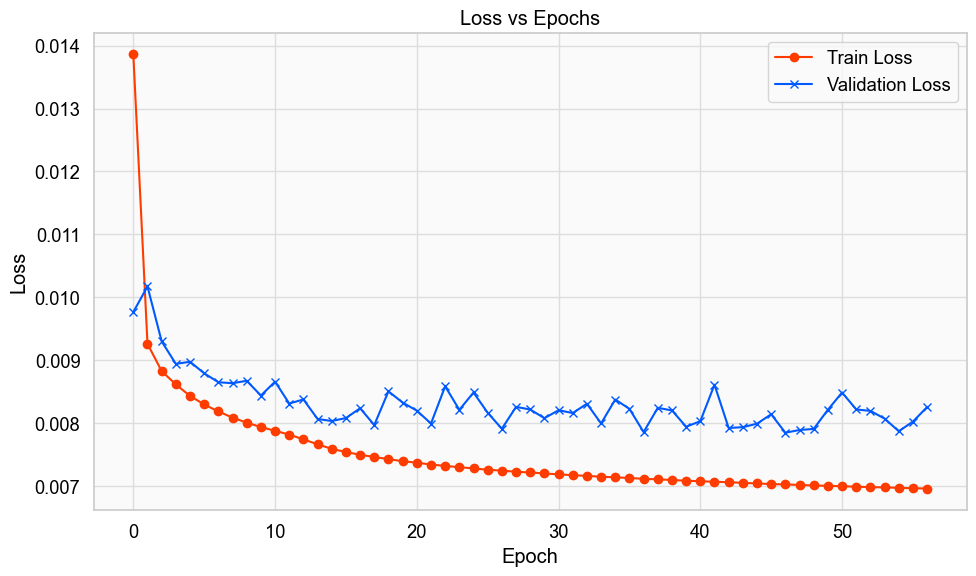

In [23]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [24]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_12540\2791210199.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_5/proposed_alibabalr=0.00001lstmfix.pth


Evaluating: 100%|██████████| 10741/10741 [00:37<00:00, 287.25it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0639
Test RMSE        : 0.0895
Test Huber Loss  : 0.0040
Test MSE Loss    : 0.0080
Avg Inference Time per Sample: 0.0136 ms
Total Evaluation Time        : 9.38 seconds


array([[0.02303484, 0.02856197, 0.03000071, ..., 0.04389578, 0.04676533,
        0.04962684],
       [0.02304223, 0.02849613, 0.0298829 , ..., 0.04376873, 0.04669979,
        0.04957344],
       [0.0233525 , 0.02872225, 0.03011579, ..., 0.04395378, 0.04687742,
        0.04969693],
       ...,
       [0.21997522, 0.2316477 , 0.23889977, ..., 0.24725589, 0.246447  ,
        0.24500953],
       [0.24111739, 0.25024867, 0.25594294, ..., 0.2519467 , 0.2511359 ,
        0.24962425],
       [0.23658948, 0.24514028, 0.2505254 , ..., 0.24868223, 0.24802954,
        0.24665555]], dtype=float32)

#### T CNN SENet LSTM

In [26]:
class TimeSeriesModel_t(nn.Module):
    def __init__(self, timesteps, features):
        super(TimeSeriesModel_t, self).__init__()
        self.framing = FramingLayer(frame_length=30, frame_step=1)
        self.reverse_framing = ReverseFramingLayer()
        
        # Stacked LSTMs with residual connections
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)  
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Equivalent to GlobalAveragePooling1D

        # Additional LSTM layers
        self.lstm5 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        
        self.dnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(features, 64, kernel_size=3, stride=(1, 1), padding='same'),  # Captures temporal patterns
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),  # Extracts deeper features
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.AdaptiveAvgPool2d((30, 16))  # Standardizes feature size for SENet
        )

        self.senet = SENet(128, ratio=16)  # SENet should match CNN output channels
        self.senet2 = SENet(64, ratio=16)  # SENet should match CNN output channels

    
    def forward(self, X):
        X = self.framing(X).permute(0, 2, 1, 3)
        X = self.cnn(X)
        X = self.senet(X)
        X = X.flatten(2).permute(0,2,1)
        
        X_res, _ = self.lstm1(X) # batch, seq_len, input_size
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm2(X_res)
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm3(X_res)


        X_res = self.dropout(X_res)
        X_lstm, _ = self.lstm4(X_res)
        
        cnn_output = self.global_avg_pool(X.permute(0, 2, 1)).squeeze(-1)  # (batch, features)
        X = X_lstm + cnn_output.unsqueeze(1)  # Broadcasting

        X, _ = self.lstm5(X)
        X = self.dropout(X)
        X, _ = self.lstm6(X)
        X = self.dropout(X)
        
        y = self.dnn(X[:, -1, :])
        return y

In [27]:
# Initialize model and move it to GPU
model = TimeSeriesModel_t(timesteps, features).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm1.weight_ih_l0                       [256, 128]                     32768
lstm1.weight_hh_l0                       [256, 64]                      16384
lstm1.bias_ih_l0                         [256]                          256
lstm1.bias_hh_l0                         [256]                          256
lstm2.weight_ih_l0                       [128, 64]                      8192
lstm2.weight_hh_l0                       [128, 32]                      4096
lstm2.bias_ih_l0                         [128]                          128
lstm2.bias_hh_l0                         [128]                          128
lstm2.weight_ih_l0_reverse               [128, 64]                      8192
lstm2.weight_hh_l0_reverse               [128, 32]                      4096
lstm2.bias_ih_l0_reverse                 [128]                        

In [28]:
checkpoint_path = "ck_1/t_cnn_se_lstm_alibaba.pth"

C:\Users\User\AppData\Local\Temp\ipykernel_31868\4142637058.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Checkpoint loaded: Resuming from epoch 12
#### TRAINING STARTED ####


Epoch 13/100: 100%|██████████| 10025/10025 [09:46<00:00, 17.08it/s]


Epoch 13 | Train Loss: 0.0038 | Val Loss: 0.0039
Checkpoint saved at epoch 13


Epoch 14/100: 100%|██████████| 10025/10025 [08:39<00:00, 19.29it/s]


Epoch 14 | Train Loss: 0.0038 | Val Loss: 0.0037
Checkpoint saved at epoch 14
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [08:03<00:00, 20.74it/s]


Epoch 15 | Train Loss: 0.0037 | Val Loss: 0.0039


Epoch 16/100: 100%|██████████| 10025/10025 [08:20<00:00, 20.01it/s]


Epoch 16 | Train Loss: 0.0037 | Val Loss: 0.0037
Checkpoint saved at epoch 16
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [10:07<00:00, 16.51it/s]


Epoch 17 | Train Loss: 0.0036 | Val Loss: 0.0040


Epoch 18/100: 100%|██████████| 10025/10025 [09:55<00:00, 16.84it/s]


Epoch 18 | Train Loss: 0.0036 | Val Loss: 0.0037
Checkpoint saved at epoch 18
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [10:08<00:00, 16.47it/s]


Epoch 19 | Train Loss: 0.0035 | Val Loss: 0.0041


Epoch 20/100: 100%|██████████| 10025/10025 [09:51<00:00, 16.96it/s]


Epoch 20 | Train Loss: 0.0035 | Val Loss: 0.0038
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [10:18<00:00, 16.22it/s]


Epoch 21 | Train Loss: 0.0035 | Val Loss: 0.0035
Checkpoint saved at epoch 21


Epoch 22/100: 100%|██████████| 10025/10025 [10:40<00:00, 15.64it/s]


Epoch 22 | Train Loss: 0.0034 | Val Loss: 0.0036
Checkpoint saved at epoch 22


Epoch 23/100: 100%|██████████| 10025/10025 [08:32<00:00, 19.57it/s]


Epoch 23 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 23


Epoch 24/100: 100%|██████████| 10025/10025 [10:10<00:00, 16.42it/s]


Epoch 24 | Train Loss: 0.0034 | Val Loss: 0.0037
Checkpoint saved at epoch 24


Epoch 25/100: 100%|██████████| 10025/10025 [10:19<00:00, 16.17it/s]


Epoch 25 | Train Loss: 0.0034 | Val Loss: 0.0038


Epoch 26/100: 100%|██████████| 10025/10025 [10:18<00:00, 16.20it/s]


Epoch 26 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 26


Epoch 27/100: 100%|██████████| 10025/10025 [06:47<00:00, 24.60it/s]


Epoch 27 | Train Loss: 0.0034 | Val Loss: 0.0036


Epoch 28/100: 100%|██████████| 10025/10025 [06:48<00:00, 24.56it/s]


Epoch 28 | Train Loss: 0.0033 | Val Loss: 0.0038
Checkpoint saved at epoch 28


Epoch 29/100: 100%|██████████| 10025/10025 [06:48<00:00, 24.54it/s]


Epoch 29 | Train Loss: 0.0033 | Val Loss: 0.0035


Epoch 30/100: 100%|██████████| 10025/10025 [06:48<00:00, 24.55it/s]


Epoch 30 | Train Loss: 0.0033 | Val Loss: 0.0037
Checkpoint saved at epoch 30


Epoch 31/100: 100%|██████████| 10025/10025 [06:48<00:00, 24.54it/s]


Epoch 31 | Train Loss: 0.0033 | Val Loss: 0.0036


Epoch 32/100: 100%|██████████| 10025/10025 [06:47<00:00, 24.57it/s]


Epoch 32 | Train Loss: 0.0033 | Val Loss: 0.0037
Checkpoint saved at epoch 32


Epoch 33/100: 100%|██████████| 10025/10025 [06:47<00:00, 24.58it/s]


Epoch 33 | Train Loss: 0.0033 | Val Loss: 0.0036
⚠️ Early stopping at epoch 33 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 11693.3 seconds
Best Validation Loss: 0.0035
Final Train Loss: 0.0033
Final Val Loss: 0.0036


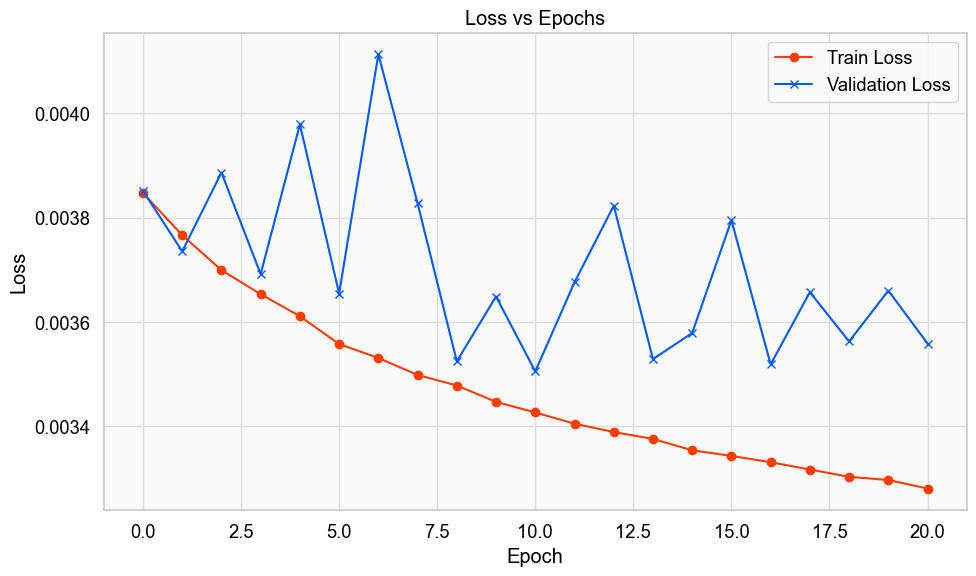

In [29]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [30]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_31868\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

TimeSeriesModel_t(
  (framing): FramingLayer()
  (reverse_framing): ReverseFramingLayer()
  (lstm1): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True, bidirectional=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (lstm4): LSTM(64, 128, batch_first=True)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (lstm5): LSTM(128, 64, batch_first=True)
  (lstm6): LSTM(64, 32, batch_first=True)
  (dnn): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (cnn): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [31]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_31868\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_1/t_cnn_se_lstm_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:27<00:00, 77.99it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0425
Test RMSE        : 0.0605
Test Huber Loss  : 0.0018
Test MSE Loss    : 0.0037
Avg Inference Time per Sample: 0.0206 ms
Total Evaluation Time        : 2.83 seconds


array([[0.07017264],
       [0.0723348 ],
       [0.0673019 ],
       ...,
       [0.2141621 ],
       [0.2318584 ],
       [0.20756221]], dtype=float32)

####  Process 2.0

In [24]:
class TimeSeriesModel(nn.Module):
    def __init__(self, timesteps, features):
        super(TimeSeriesModel, self).__init__()
        self.fft = FourierTransformLayer()
        self.framing = FramingLayer(frame_length=30, frame_step=1)
        self.reverse_framing = ReverseFramingLayer()

        # Stacked LSTMs with residual connections
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)

        self.dnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(features*2, 64, kernel_size=3, stride=(1, 1), padding='same'),  # Captures temporal patterns
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),  # Extracts deeper features
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.AdaptiveAvgPool2d((30, 16))  # Standardizes feature size for SENet
        )

        self.senet = SENet(128, ratio=16)  # SENet should match CNN output channels
        self.senet2 = SENet(64, ratio=16)  # SENet should match CNN output channels


    def forward(self, X):
        X_freq = self.fft(X)
        X_freq = self.senet2(X_freq)
        X = torch.cat([X, X_freq], dim=-1)
        X = self.framing(X).permute(0, 2, 1, 3)
        X = self.cnn(X)
        X = self.senet(X)

        # Replace flatten with global average pooling
        X = F.adaptive_avg_pool2d(X, (1, 1))  # Global average pool over H, W
        X = X.view(X.size(0), 1, -1)          # Reshape to (batch, seq_len=1, features)

        X_res, _ = self.lstm1(X)
        X_res = self.dropout(X_res)
        X, _ = self.lstm6(X_res)
        X = self.dropout(X)

        y = self.dnn(X[:, -1, :])
        return y

In [25]:
# Initialize model and move it to GPU
model = TimeSeriesModel(timesteps, features).to(device)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
# loss_fn = nn.HuberLoss(delta=1.0)
loss_fn = nn.MSELoss()
print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm1.weight_ih_l0                       [256, 128]                     32768
lstm1.weight_hh_l0                       [256, 64]                      16384
lstm1.bias_ih_l0                         [256]                          256
lstm1.bias_hh_l0                         [256]                          256
lstm6.weight_ih_l0                       [128, 64]                      8192
lstm6.weight_hh_l0                       [128, 32]                      4096
lstm6.bias_ih_l0                         [128]                          128
lstm6.bias_hh_l0                         [128]                          128
dnn.0.weight                             [32, 32]                       1024
dnn.0.bias                               [32]                           32
dnn.2.weight                             [1, 32]                        

In [26]:
checkpoint_path = "ck_1/proposed_alibaba_101k.pth"

#### TRAINING STARTED ####


Epoch 1/200: 100%|██████████| 10025/10025 [01:18<00:00, 127.09it/s]


Epoch 01 | Train Loss: 0.0324 | Val Loss: 0.0107
Checkpoint saved at epoch 1


Epoch 2/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.64it/s]


Epoch 02 | Train Loss: 0.0102 | Val Loss: 0.0098
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.31it/s]


Epoch 03 | Train Loss: 0.0096 | Val Loss: 0.0095
Checkpoint saved at epoch 3


Epoch 4/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.49it/s]


Epoch 04 | Train Loss: 0.0093 | Val Loss: 0.0094
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.99it/s]


Epoch 05 | Train Loss: 0.0091 | Val Loss: 0.0093
Checkpoint saved at epoch 5


Epoch 6/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.94it/s]


Epoch 06 | Train Loss: 0.0089 | Val Loss: 0.0091
Checkpoint saved at epoch 6
Checkpoint saved at epoch 6


Epoch 7/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.69it/s]


Epoch 07 | Train Loss: 0.0088 | Val Loss: 0.0090
Checkpoint saved at epoch 7


Epoch 8/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.72it/s]


Epoch 08 | Train Loss: 0.0087 | Val Loss: 0.0091
Checkpoint saved at epoch 8


Epoch 9/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.87it/s]


Epoch 09 | Train Loss: 0.0086 | Val Loss: 0.0088
Checkpoint saved at epoch 9


Epoch 10/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.15it/s]


Epoch 10 | Train Loss: 0.0085 | Val Loss: 0.0087
Checkpoint saved at epoch 10
Checkpoint saved at epoch 10


Epoch 11/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.13it/s]


Epoch 11 | Train Loss: 0.0084 | Val Loss: 0.0086
Checkpoint saved at epoch 11


Epoch 12/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.91it/s]


Epoch 12 | Train Loss: 0.0083 | Val Loss: 0.0087
Checkpoint saved at epoch 12


Epoch 13/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.89it/s]


Epoch 13 | Train Loss: 0.0082 | Val Loss: 0.0084
Checkpoint saved at epoch 13


Epoch 14/200: 100%|██████████| 10025/10025 [01:17<00:00, 130.15it/s]


Epoch 14 | Train Loss: 0.0081 | Val Loss: 0.0083
Checkpoint saved at epoch 14
Checkpoint saved at epoch 14


Epoch 15/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.99it/s]


Epoch 15 | Train Loss: 0.0079 | Val Loss: 0.0082
Checkpoint saved at epoch 15


Epoch 16/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.09it/s]


Epoch 16 | Train Loss: 0.0078 | Val Loss: 0.0081
Checkpoint saved at epoch 16
Checkpoint saved at epoch 16


Epoch 17/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.89it/s]


Epoch 17 | Train Loss: 0.0077 | Val Loss: 0.0087


Epoch 18/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.67it/s]


Epoch 18 | Train Loss: 0.0076 | Val Loss: 0.0078
Checkpoint saved at epoch 18
Checkpoint saved at epoch 18


Epoch 19/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.82it/s]


Epoch 19 | Train Loss: 0.0075 | Val Loss: 0.0078


Epoch 20/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.11it/s]


Epoch 20 | Train Loss: 0.0074 | Val Loss: 0.0077
Checkpoint saved at epoch 20
Checkpoint saved at epoch 20


Epoch 21/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.99it/s]


Epoch 21 | Train Loss: 0.0073 | Val Loss: 0.0074
Checkpoint saved at epoch 21


Epoch 22/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.02it/s]


Epoch 22 | Train Loss: 0.0072 | Val Loss: 0.0076
Checkpoint saved at epoch 22


Epoch 23/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.95it/s]


Epoch 23 | Train Loss: 0.0071 | Val Loss: 0.0074
Checkpoint saved at epoch 23


Epoch 24/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.93it/s]


Epoch 24 | Train Loss: 0.0071 | Val Loss: 0.0075
Checkpoint saved at epoch 24


Epoch 25/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.16it/s]


Epoch 25 | Train Loss: 0.0070 | Val Loss: 0.0072
Checkpoint saved at epoch 25


Epoch 26/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.99it/s]


Epoch 26 | Train Loss: 0.0070 | Val Loss: 0.0081
Checkpoint saved at epoch 26


Epoch 27/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.00it/s]


Epoch 27 | Train Loss: 0.0069 | Val Loss: 0.0070
Checkpoint saved at epoch 27


Epoch 28/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.59it/s]


Epoch 28 | Train Loss: 0.0068 | Val Loss: 0.0071
Checkpoint saved at epoch 28


Epoch 29/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.70it/s]


Epoch 29 | Train Loss: 0.0068 | Val Loss: 0.0069
Checkpoint saved at epoch 29


Epoch 30/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.09it/s]


Epoch 30 | Train Loss: 0.0067 | Val Loss: 0.0070
Checkpoint saved at epoch 30


Epoch 31/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.15it/s]


Epoch 31 | Train Loss: 0.0067 | Val Loss: 0.0067
Checkpoint saved at epoch 31


Epoch 32/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.03it/s]


Epoch 32 | Train Loss: 0.0067 | Val Loss: 0.0067
Checkpoint saved at epoch 32
Checkpoint saved at epoch 32


Epoch 33/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.82it/s]


Epoch 33 | Train Loss: 0.0066 | Val Loss: 0.0067


Epoch 34/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.87it/s]


Epoch 34 | Train Loss: 0.0066 | Val Loss: 0.0067
Checkpoint saved at epoch 34


Epoch 35/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.14it/s]


Epoch 35 | Train Loss: 0.0066 | Val Loss: 0.0067
Checkpoint saved at epoch 35


Epoch 36/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.08it/s]


Epoch 36 | Train Loss: 0.0065 | Val Loss: 0.0066
Checkpoint saved at epoch 36
Checkpoint saved at epoch 36


Epoch 37/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.04it/s]


Epoch 37 | Train Loss: 0.0065 | Val Loss: 0.0065
Checkpoint saved at epoch 37


Epoch 38/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.68it/s]


Epoch 38 | Train Loss: 0.0065 | Val Loss: 0.0071
Checkpoint saved at epoch 38


Epoch 39/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.65it/s]


Epoch 39 | Train Loss: 0.0065 | Val Loss: 0.0065


Epoch 40/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.94it/s]


Epoch 40 | Train Loss: 0.0064 | Val Loss: 0.0067
Checkpoint saved at epoch 40


Epoch 41/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.16it/s]


Epoch 41 | Train Loss: 0.0064 | Val Loss: 0.0063
Checkpoint saved at epoch 41


Epoch 42/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.06it/s]


Epoch 42 | Train Loss: 0.0064 | Val Loss: 0.0084
Checkpoint saved at epoch 42


Epoch 43/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.94it/s]


Epoch 43 | Train Loss: 0.0064 | Val Loss: 0.0067


Epoch 44/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.94it/s]


Epoch 44 | Train Loss: 0.0063 | Val Loss: 0.0066
Checkpoint saved at epoch 44


Epoch 45/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.05it/s]


Epoch 45 | Train Loss: 0.0063 | Val Loss: 0.0062
Checkpoint saved at epoch 45


Epoch 46/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.02it/s]


Epoch 46 | Train Loss: 0.0063 | Val Loss: 0.0064
Checkpoint saved at epoch 46


Epoch 47/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.99it/s]


Epoch 47 | Train Loss: 0.0063 | Val Loss: 0.0063


Epoch 48/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.69it/s]


Epoch 48 | Train Loss: 0.0063 | Val Loss: 0.0070
Checkpoint saved at epoch 48


Epoch 49/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.63it/s]


Epoch 49 | Train Loss: 0.0063 | Val Loss: 0.0064


Epoch 50/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.85it/s]


Epoch 50 | Train Loss: 0.0062 | Val Loss: 0.0063
Checkpoint saved at epoch 50


Epoch 51/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.16it/s]


Epoch 51 | Train Loss: 0.0062 | Val Loss: 0.0063


Epoch 52/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.06it/s]


Epoch 52 | Train Loss: 0.0062 | Val Loss: 0.0095
Checkpoint saved at epoch 52


Epoch 53/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.92it/s]


Epoch 53 | Train Loss: 0.0062 | Val Loss: 0.0061
Checkpoint saved at epoch 53


Epoch 54/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.89it/s]


Epoch 54 | Train Loss: 0.0062 | Val Loss: 0.0062
Checkpoint saved at epoch 54


Epoch 55/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.05it/s]


Epoch 55 | Train Loss: 0.0062 | Val Loss: 0.0061


Epoch 56/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.08it/s]


Epoch 56 | Train Loss: 0.0062 | Val Loss: 0.0063
Checkpoint saved at epoch 56


Epoch 57/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.03it/s]


Epoch 57 | Train Loss: 0.0061 | Val Loss: 0.0062


Epoch 58/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.85it/s]


Epoch 58 | Train Loss: 0.0061 | Val Loss: 0.0064
Checkpoint saved at epoch 58


Epoch 59/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.71it/s]


Epoch 59 | Train Loss: 0.0061 | Val Loss: 0.0062


Epoch 60/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.86it/s]


Epoch 60 | Train Loss: 0.0061 | Val Loss: 0.0067
Checkpoint saved at epoch 60


Epoch 61/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.17it/s]


Epoch 61 | Train Loss: 0.0061 | Val Loss: 0.0060
Checkpoint saved at epoch 61


Epoch 62/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.06it/s]


Epoch 62 | Train Loss: 0.0061 | Val Loss: 0.0065
Checkpoint saved at epoch 62


Epoch 63/200: 100%|██████████| 10025/10025 [01:17<00:00, 130.08it/s]


Epoch 63 | Train Loss: 0.0061 | Val Loss: 0.0060
Checkpoint saved at epoch 63


Epoch 64/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.51it/s]


Epoch 64 | Train Loss: 0.0061 | Val Loss: 0.0060
Checkpoint saved at epoch 64


Epoch 65/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.59it/s]


Epoch 65 | Train Loss: 0.0061 | Val Loss: 0.0062


Epoch 66/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.71it/s]


Epoch 66 | Train Loss: 0.0061 | Val Loss: 0.0062
Checkpoint saved at epoch 66


Epoch 67/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.86it/s]


Epoch 67 | Train Loss: 0.0061 | Val Loss: 0.0062


Epoch 68/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.67it/s]


Epoch 68 | Train Loss: 0.0060 | Val Loss: 0.0070
Checkpoint saved at epoch 68


Epoch 69/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.64it/s]


Epoch 69 | Train Loss: 0.0060 | Val Loss: 0.0059
Checkpoint saved at epoch 69


Epoch 70/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.31it/s]


Epoch 70 | Train Loss: 0.0060 | Val Loss: 0.0063
Checkpoint saved at epoch 70


Epoch 71/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.96it/s]


Epoch 71 | Train Loss: 0.0060 | Val Loss: 0.0060


Epoch 72/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.92it/s]


Epoch 72 | Train Loss: 0.0060 | Val Loss: 0.0063
Checkpoint saved at epoch 72


Epoch 73/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.85it/s]


Epoch 73 | Train Loss: 0.0060 | Val Loss: 0.0061


Epoch 74/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.85it/s]


Epoch 74 | Train Loss: 0.0060 | Val Loss: 0.0059
Checkpoint saved at epoch 74
Checkpoint saved at epoch 74


Epoch 75/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.84it/s]


Epoch 75 | Train Loss: 0.0060 | Val Loss: 0.0061


Epoch 76/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.83it/s]


Epoch 76 | Train Loss: 0.0060 | Val Loss: 0.0064
Checkpoint saved at epoch 76


Epoch 77/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.87it/s]


Epoch 77 | Train Loss: 0.0060 | Val Loss: 0.0067


Epoch 78/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.69it/s]


Epoch 78 | Train Loss: 0.0060 | Val Loss: 0.0062
Checkpoint saved at epoch 78


Epoch 79/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.63it/s]


Epoch 79 | Train Loss: 0.0060 | Val Loss: 0.0063


Epoch 80/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.00it/s]


Epoch 80 | Train Loss: 0.0060 | Val Loss: 0.0059
Checkpoint saved at epoch 80
Checkpoint saved at epoch 80


Epoch 81/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.14it/s]


Epoch 81 | Train Loss: 0.0060 | Val Loss: 0.0059


Epoch 82/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.23it/s]


Epoch 82 | Train Loss: 0.0059 | Val Loss: 0.0078
Checkpoint saved at epoch 82


Epoch 83/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.09it/s]


Epoch 83 | Train Loss: 0.0060 | Val Loss: 0.0061


Epoch 84/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.76it/s]


Epoch 84 | Train Loss: 0.0059 | Val Loss: 0.0060
Checkpoint saved at epoch 84


Epoch 85/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.57it/s]


Epoch 85 | Train Loss: 0.0059 | Val Loss: 0.0062


Epoch 86/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.97it/s]


Epoch 86 | Train Loss: 0.0059 | Val Loss: 0.0059
Checkpoint saved at epoch 86


Epoch 87/200: 100%|██████████| 10025/10025 [01:16<00:00, 131.00it/s]


Epoch 87 | Train Loss: 0.0059 | Val Loss: 0.0076


Epoch 88/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.87it/s]


Epoch 88 | Train Loss: 0.0059 | Val Loss: 0.0060
Checkpoint saved at epoch 88


Epoch 89/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.86it/s]


Epoch 89 | Train Loss: 0.0059 | Val Loss: 0.0060


Epoch 90/200: 100%|██████████| 10025/10025 [01:16<00:00, 130.92it/s]


Epoch 90 | Train Loss: 0.0059 | Val Loss: 0.0064
⚠️ Early stopping at epoch 90 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 7456.24 seconds
Best Validation Loss: 0.0059
Final Train Loss: 0.0059
Final Val Loss: 0.0064


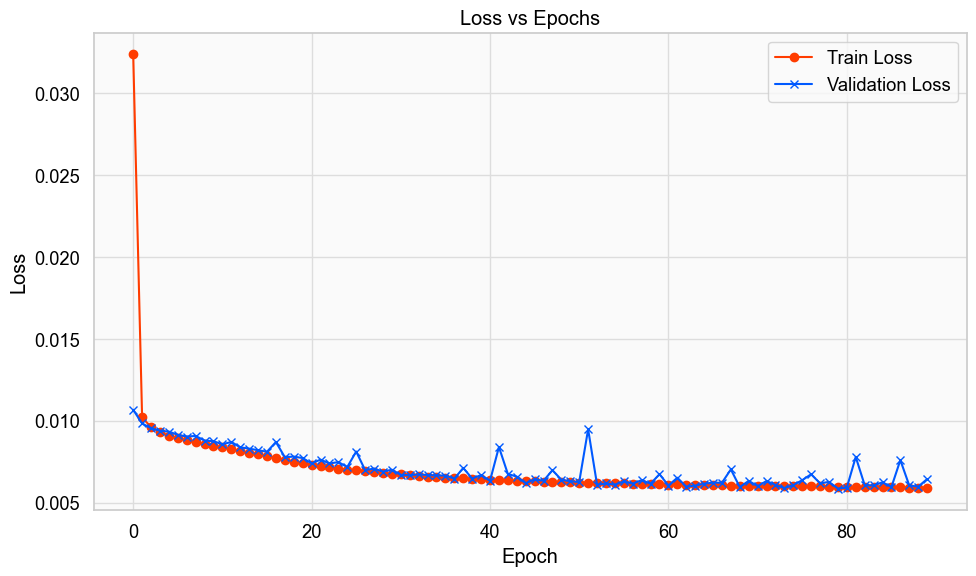

In [27]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=200, patience=10, path=checkpoint_path)

In [28]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

Checkpoint loaded from ck_1/proposed_alibaba_101k.pth

C:\Users\User\AppData\Local\Temp\ipykernel_17616\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Evaluating: 100%|██████████| 2147/2147 [00:06<00:00, 340.00it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0550
Test RMSE        : 0.0777
Test Huber Loss  : 0.0030
Test MSE Loss    : 0.0060
Avg Inference Time per Sample: 0.0122 ms
Total Evaluation Time        : 1.68 seconds


In [29]:
print(predictions.shape)
print(y_test.shape)

(137408, 1)
torch.Size([137452, 1])


In [30]:
def visualize_first_target_across_samples(y_true, y_pred=None):
    """
    Plots the first target value from each sample across the entire dataset.

    Args:
        y_true (np.ndarray): Ground truth targets of shape (samples, horizon).
        y_pred (np.ndarray, optional): Predicted targets of shape (samples, horizon). Default is None.
    """
    first_targets = y_true[:, 0]  # First point of each sample

    plt.figure(figsize=(12, 5))
    plt.plot(first_targets, label='Target: cpu_difference (first step)', linestyle='--', color='blue', alpha=0.5)

    if y_pred is not None:
        first_preds = y_pred[:, 0]
        plt.plot(first_preds, label='Prediction: cpu_difference (first step)', linestyle='-.', color='red')

    plt.xlabel('Sample Index')
    plt.ylabel('cpu_difference')
    plt.title('First Forecast Step across All Samples')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


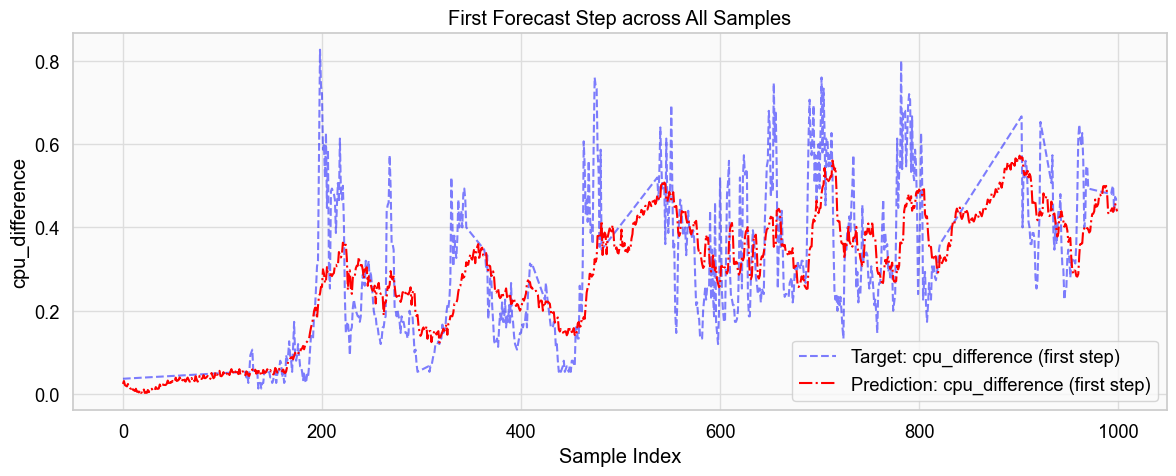

In [31]:
visualize_first_target_across_samples(y_test[0:1000], predictions[0:1000])


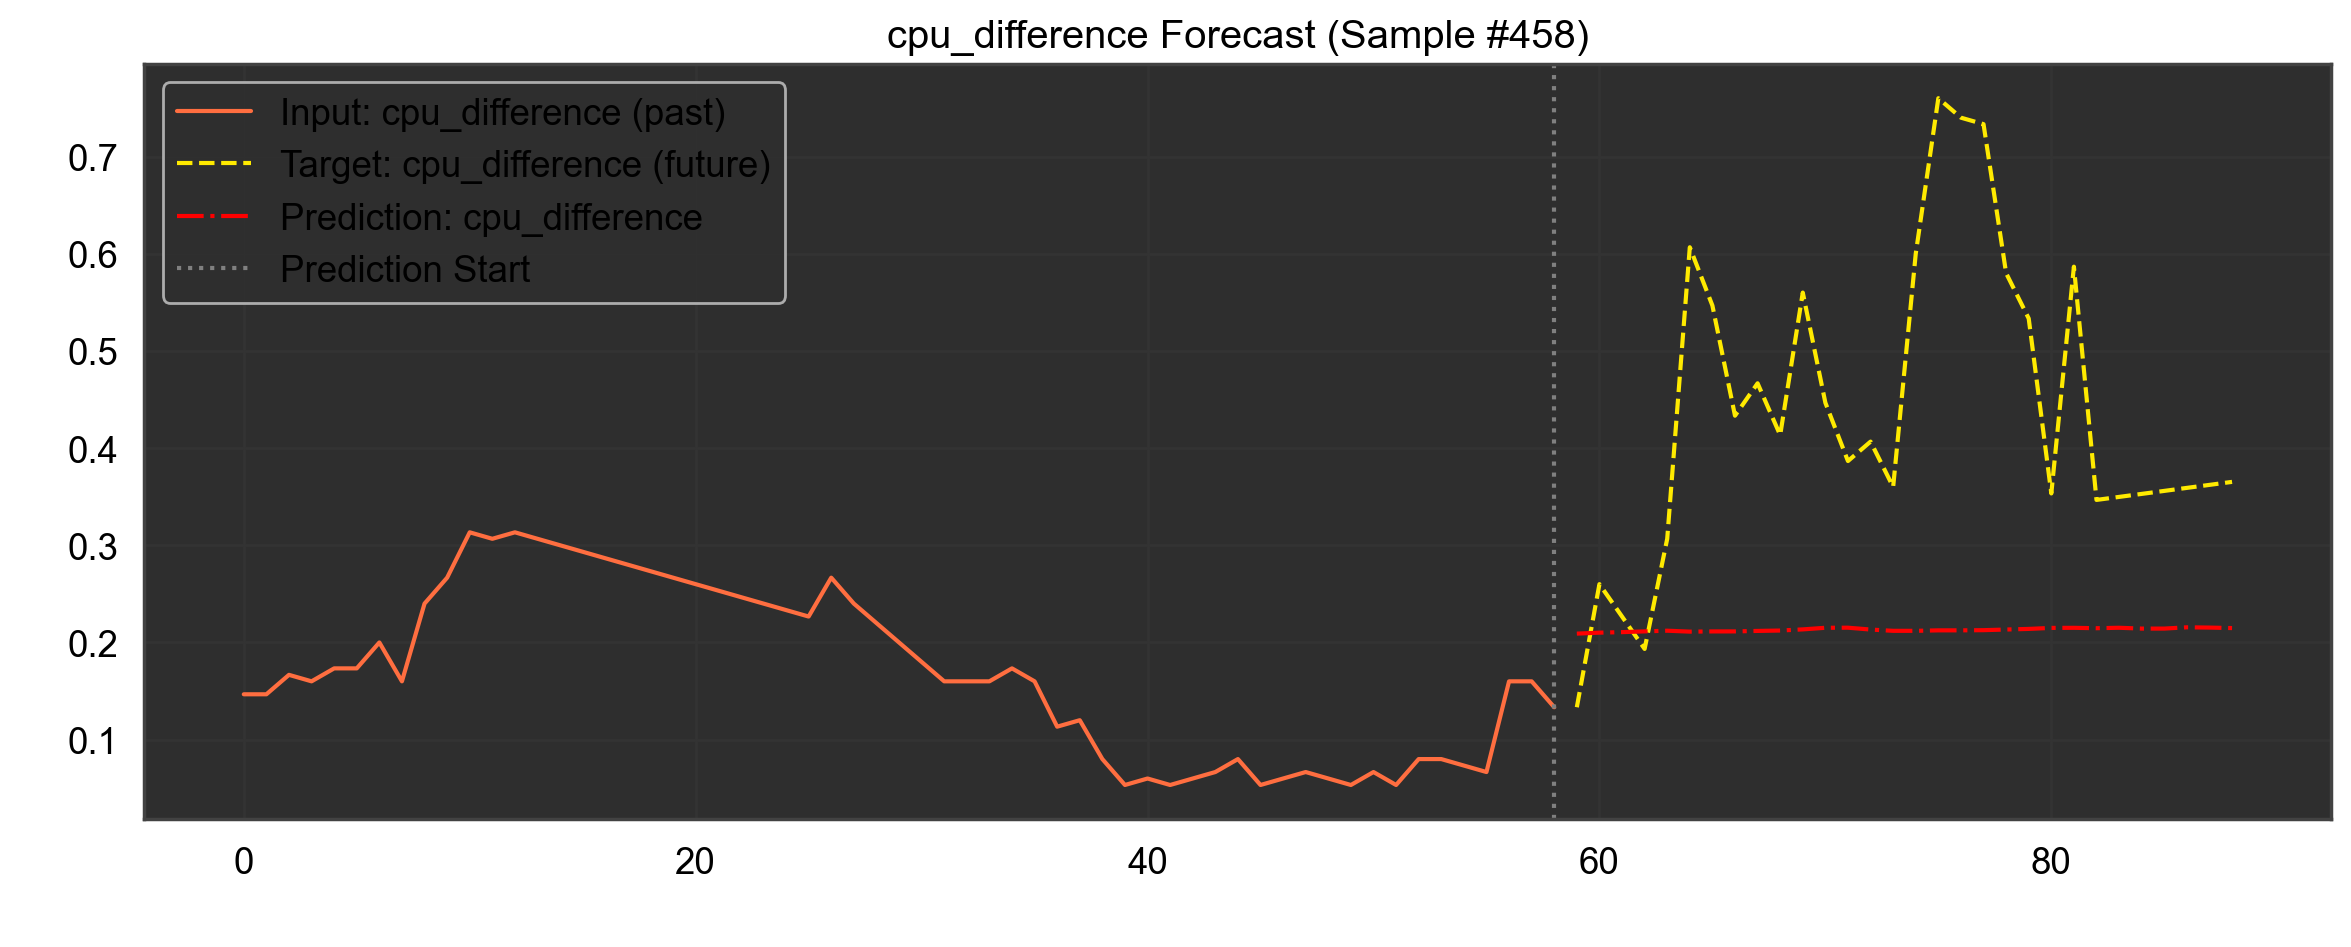

In [ ]:
visualize_target_sequence(X_test, y_test, predictions, sample_idx=458)

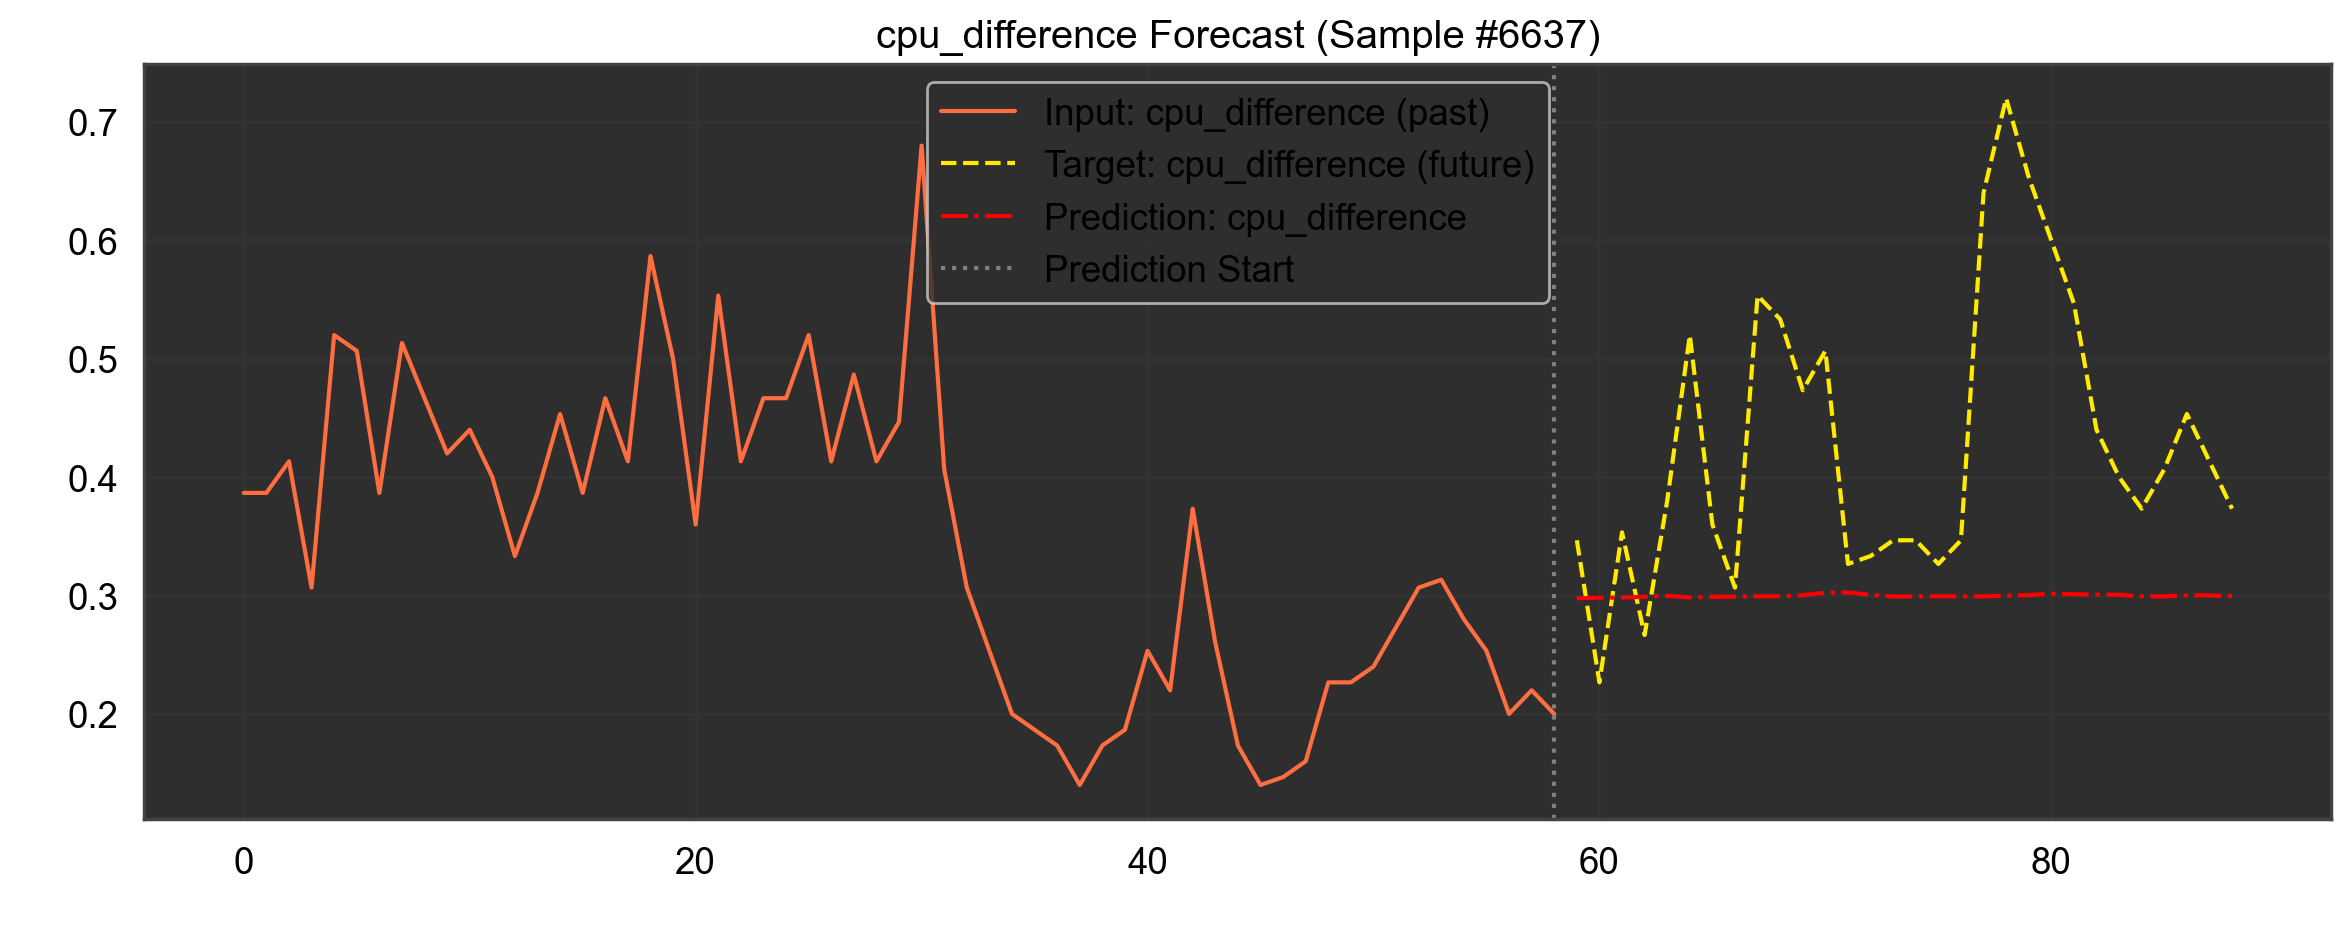

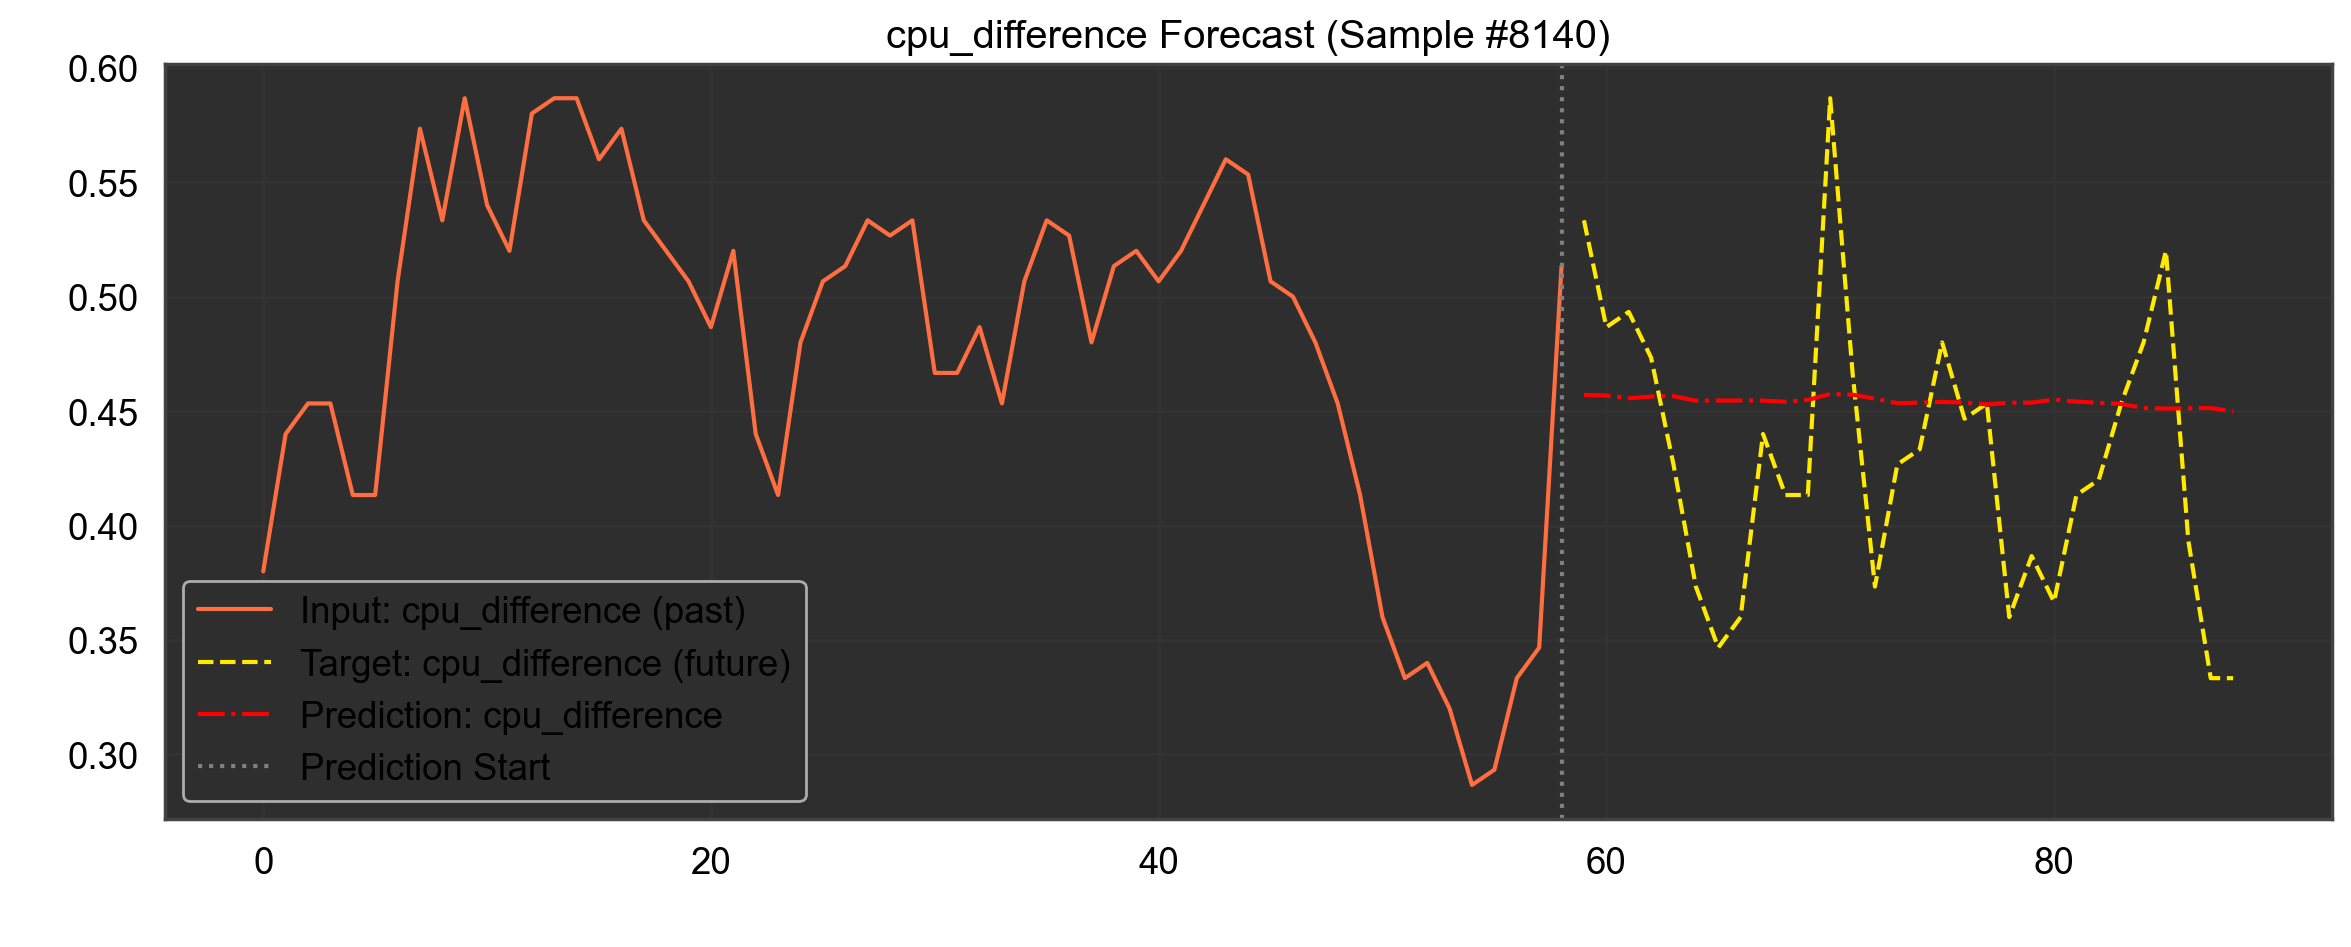

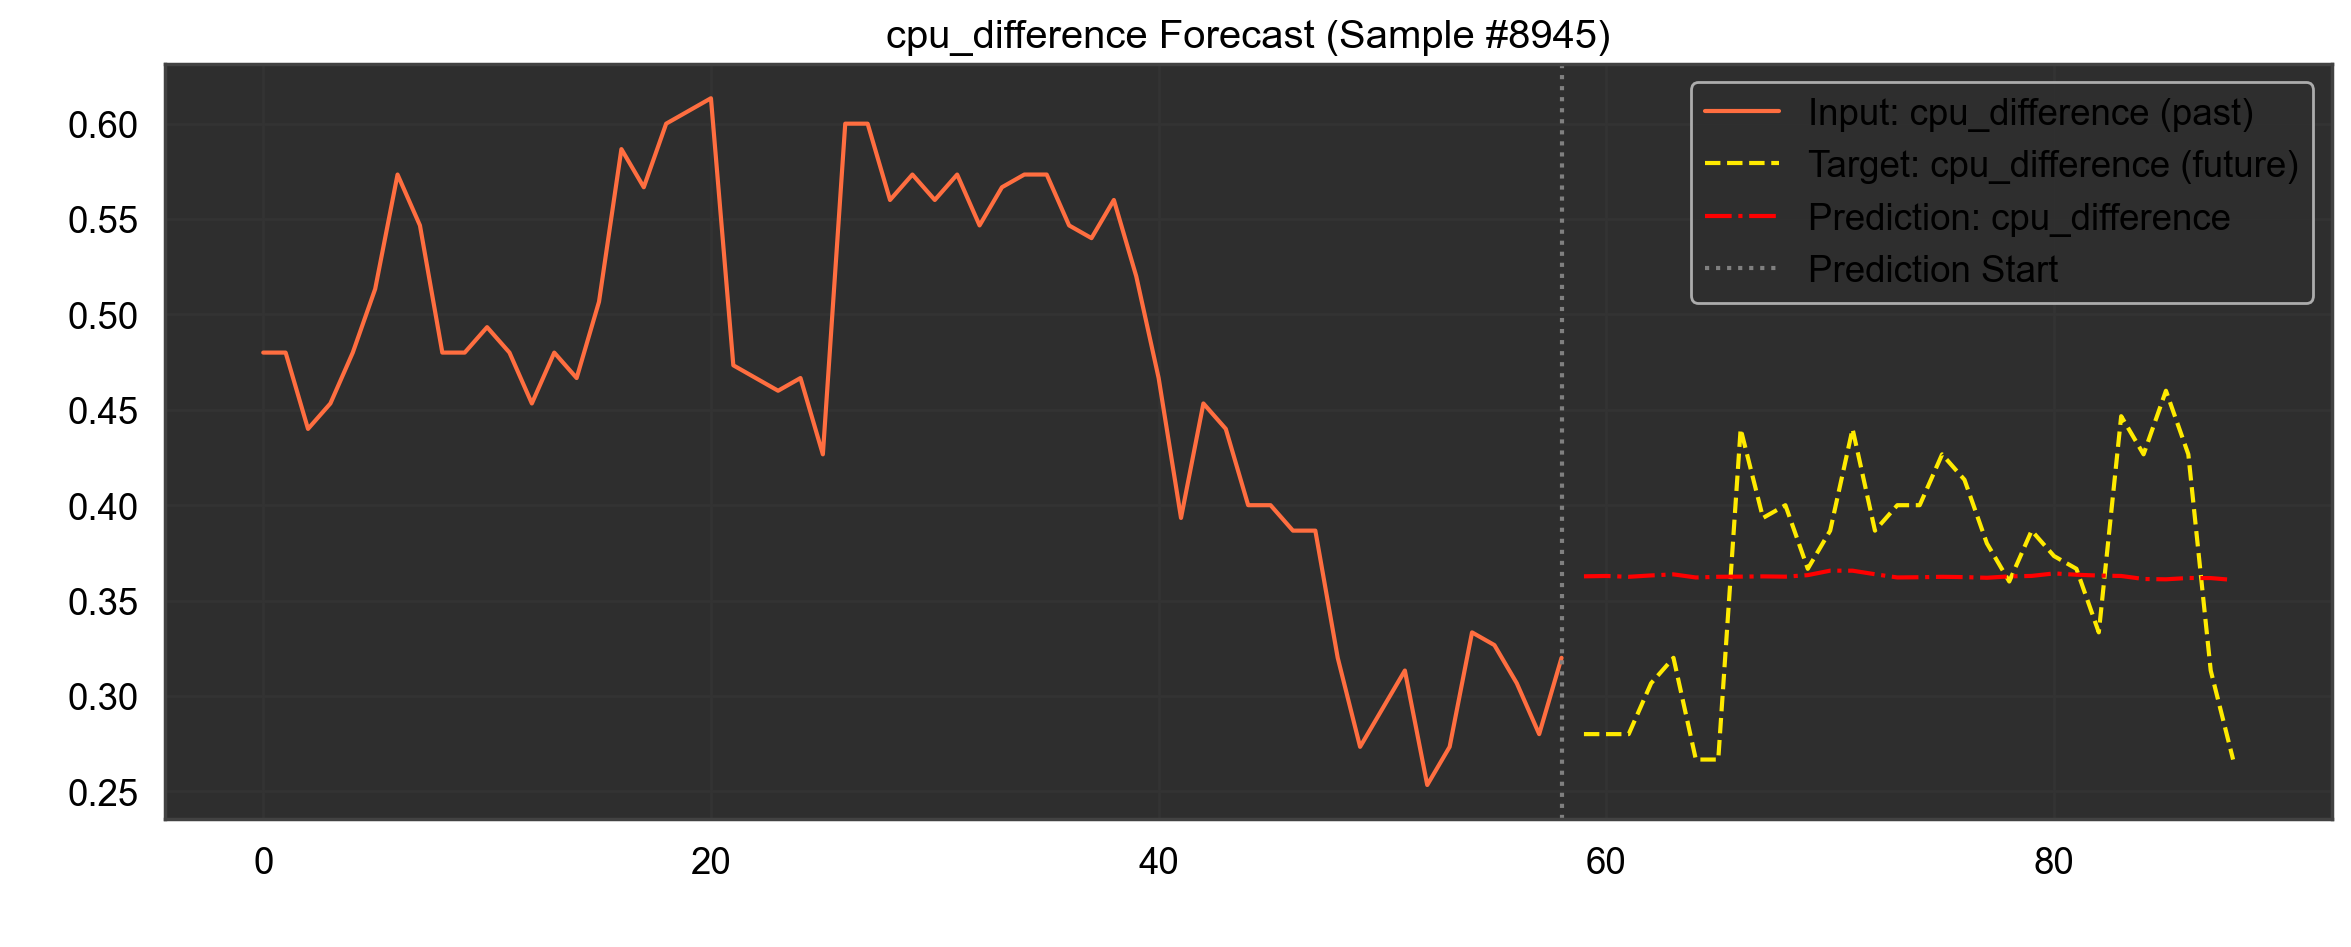

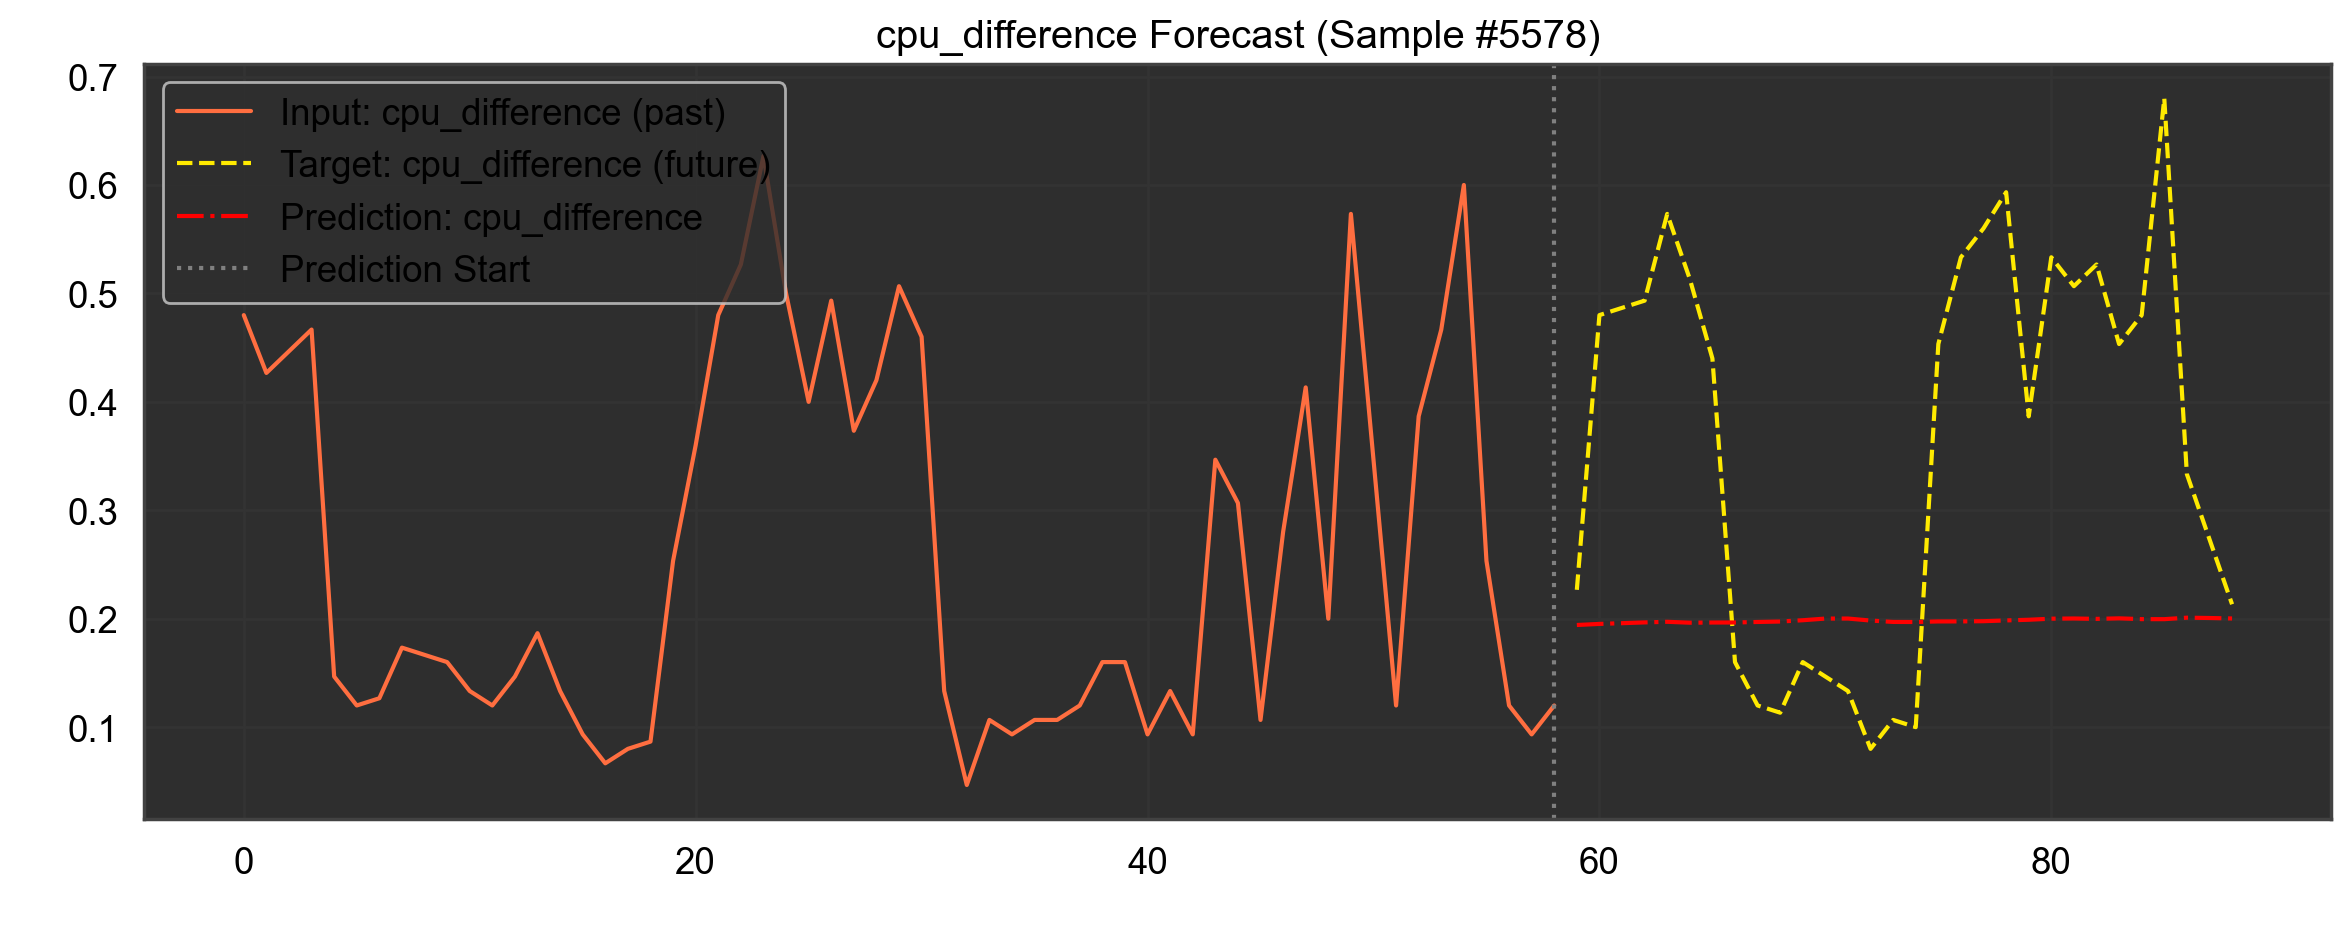

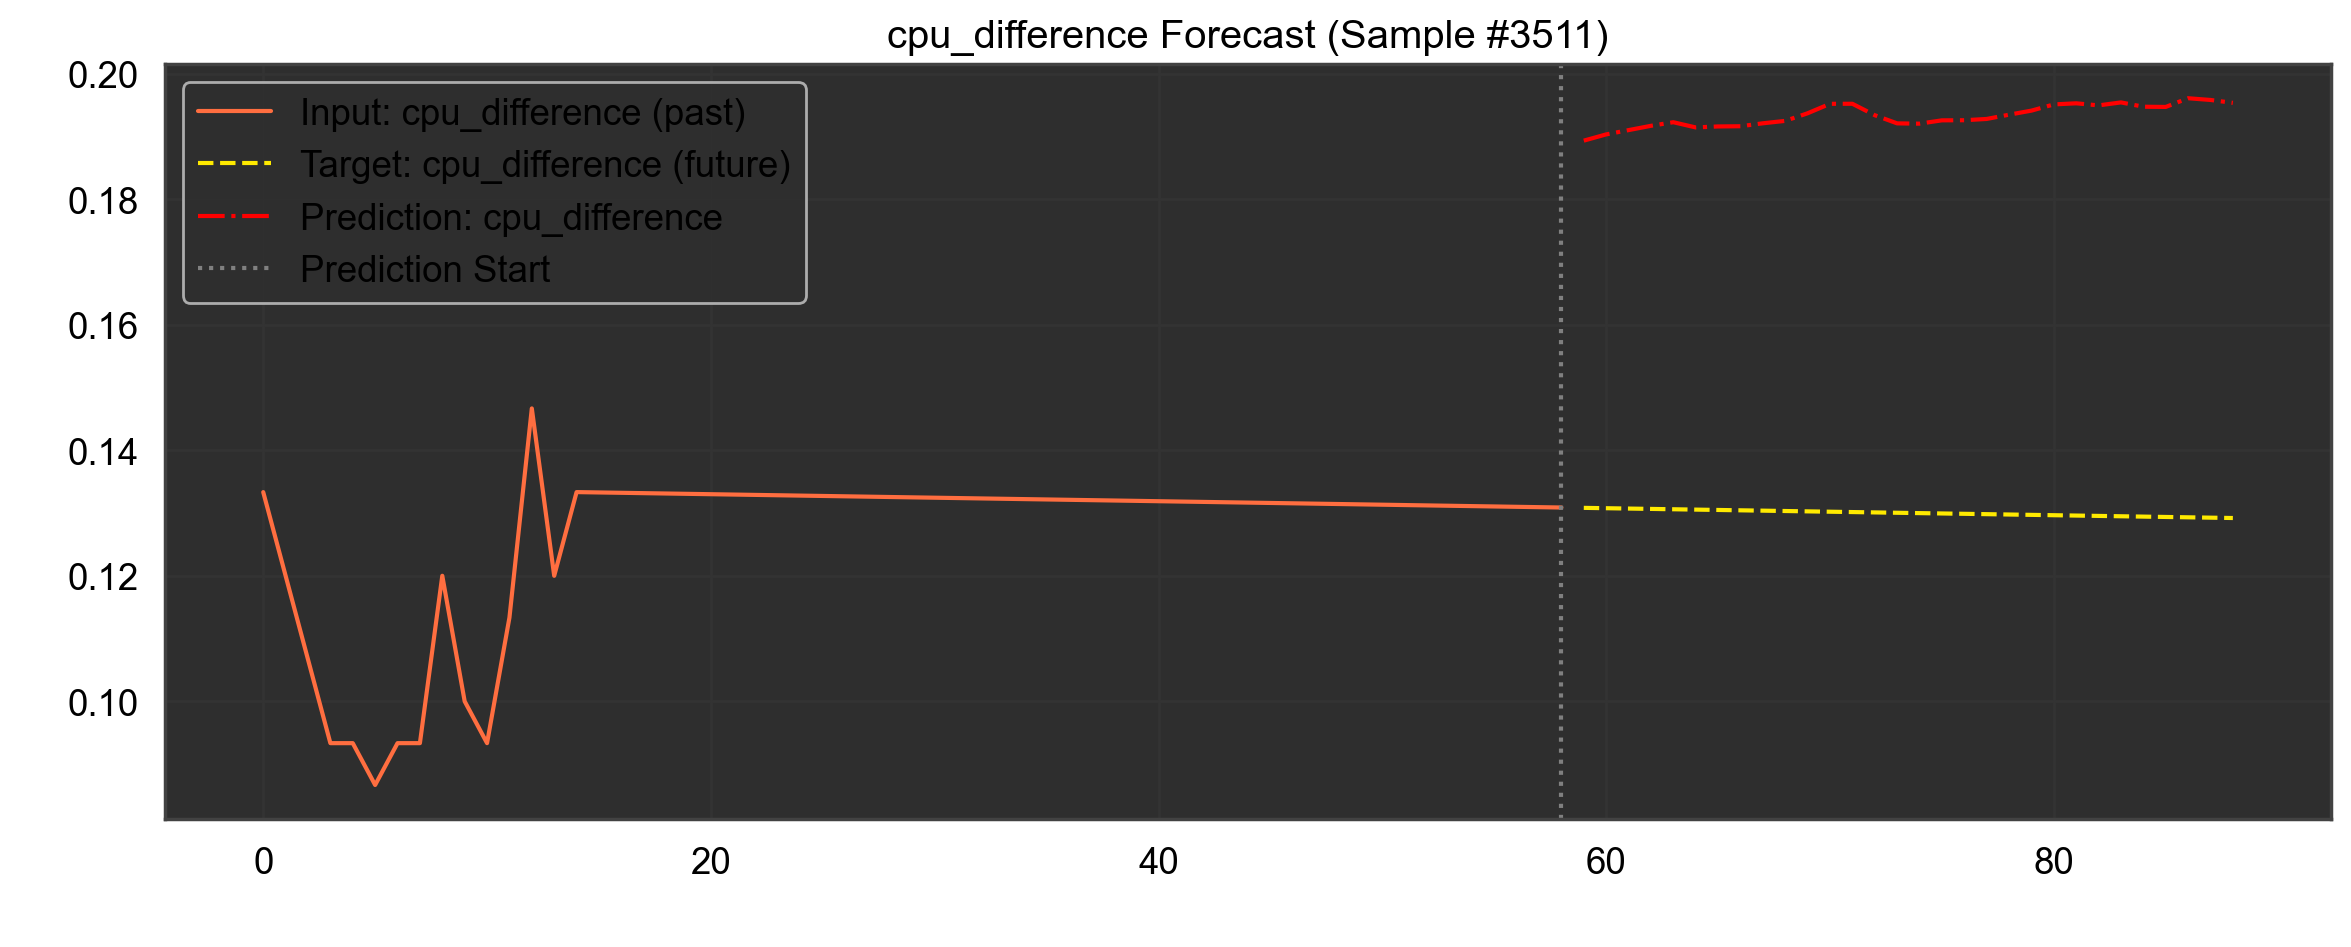

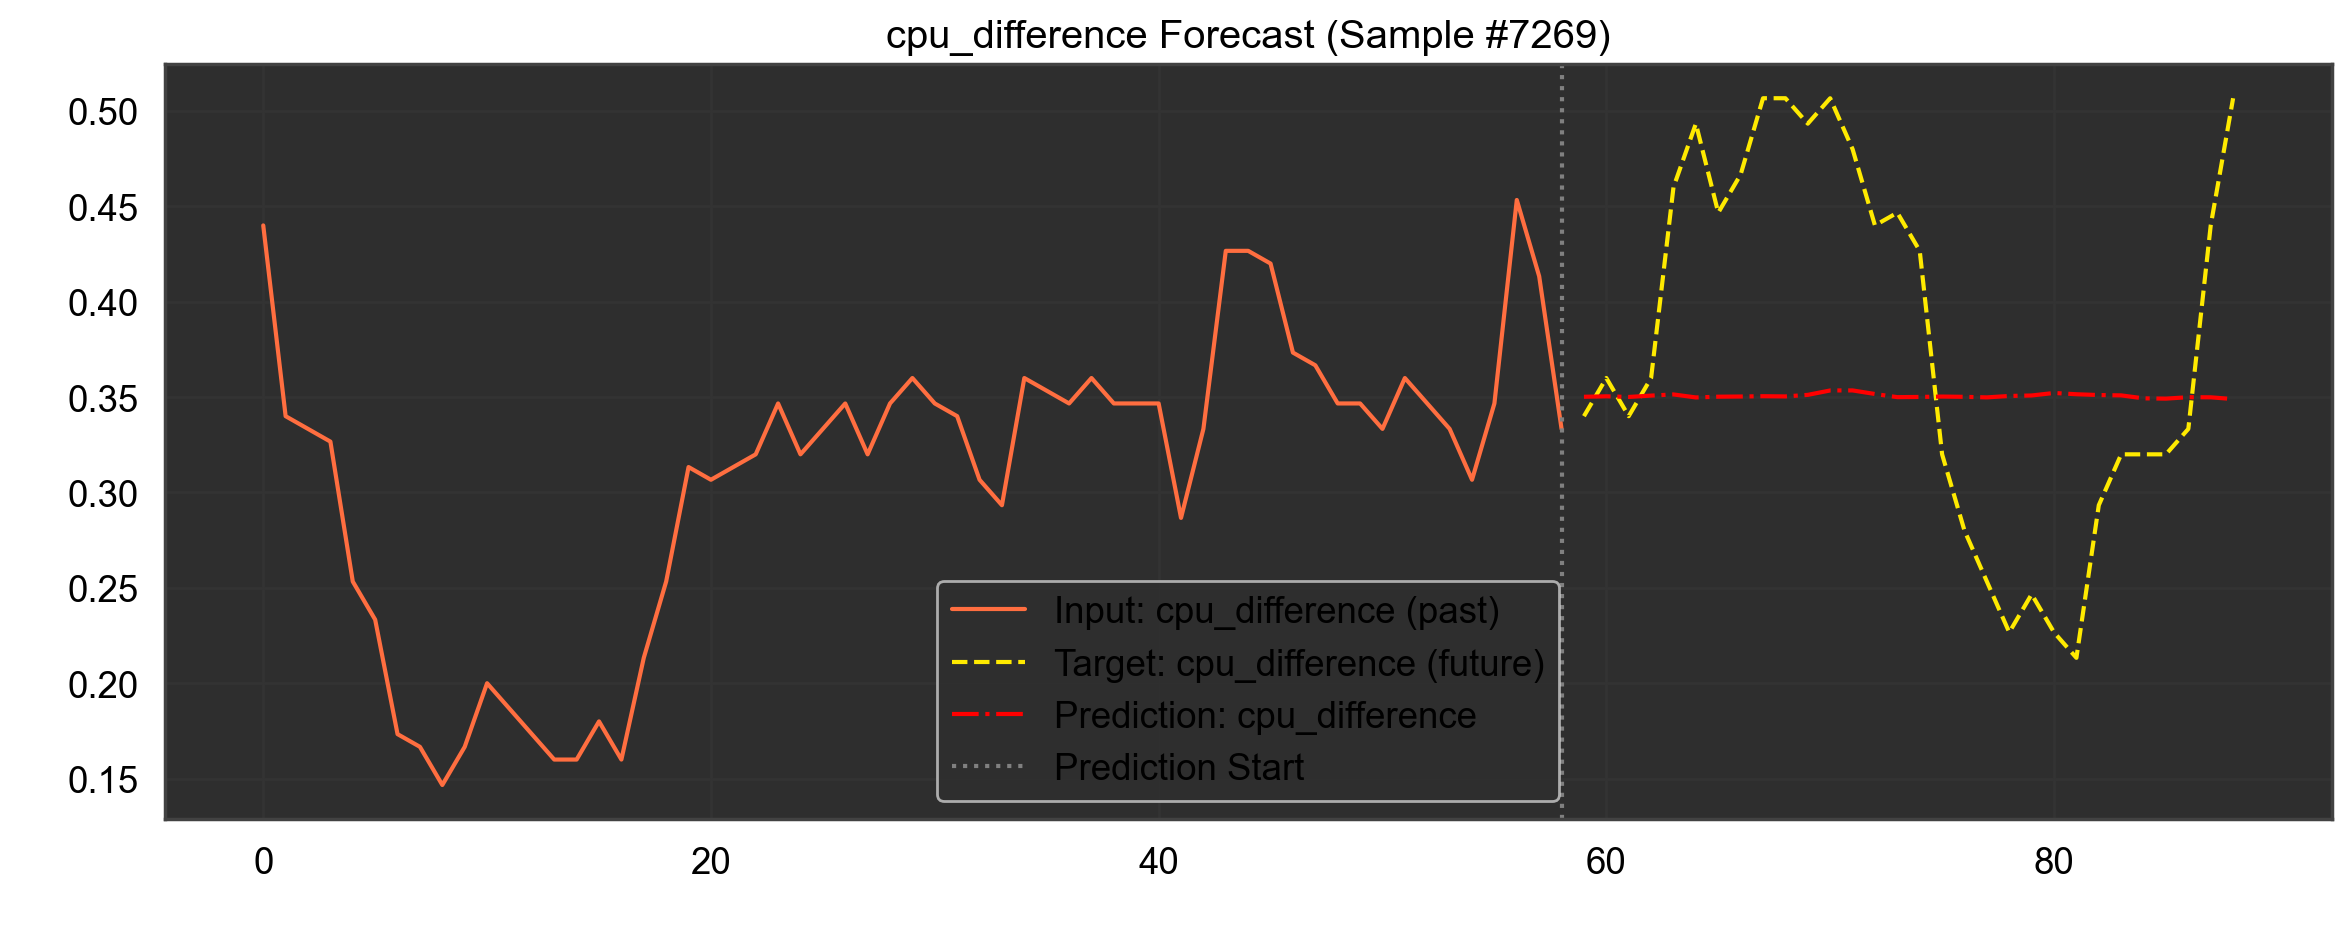

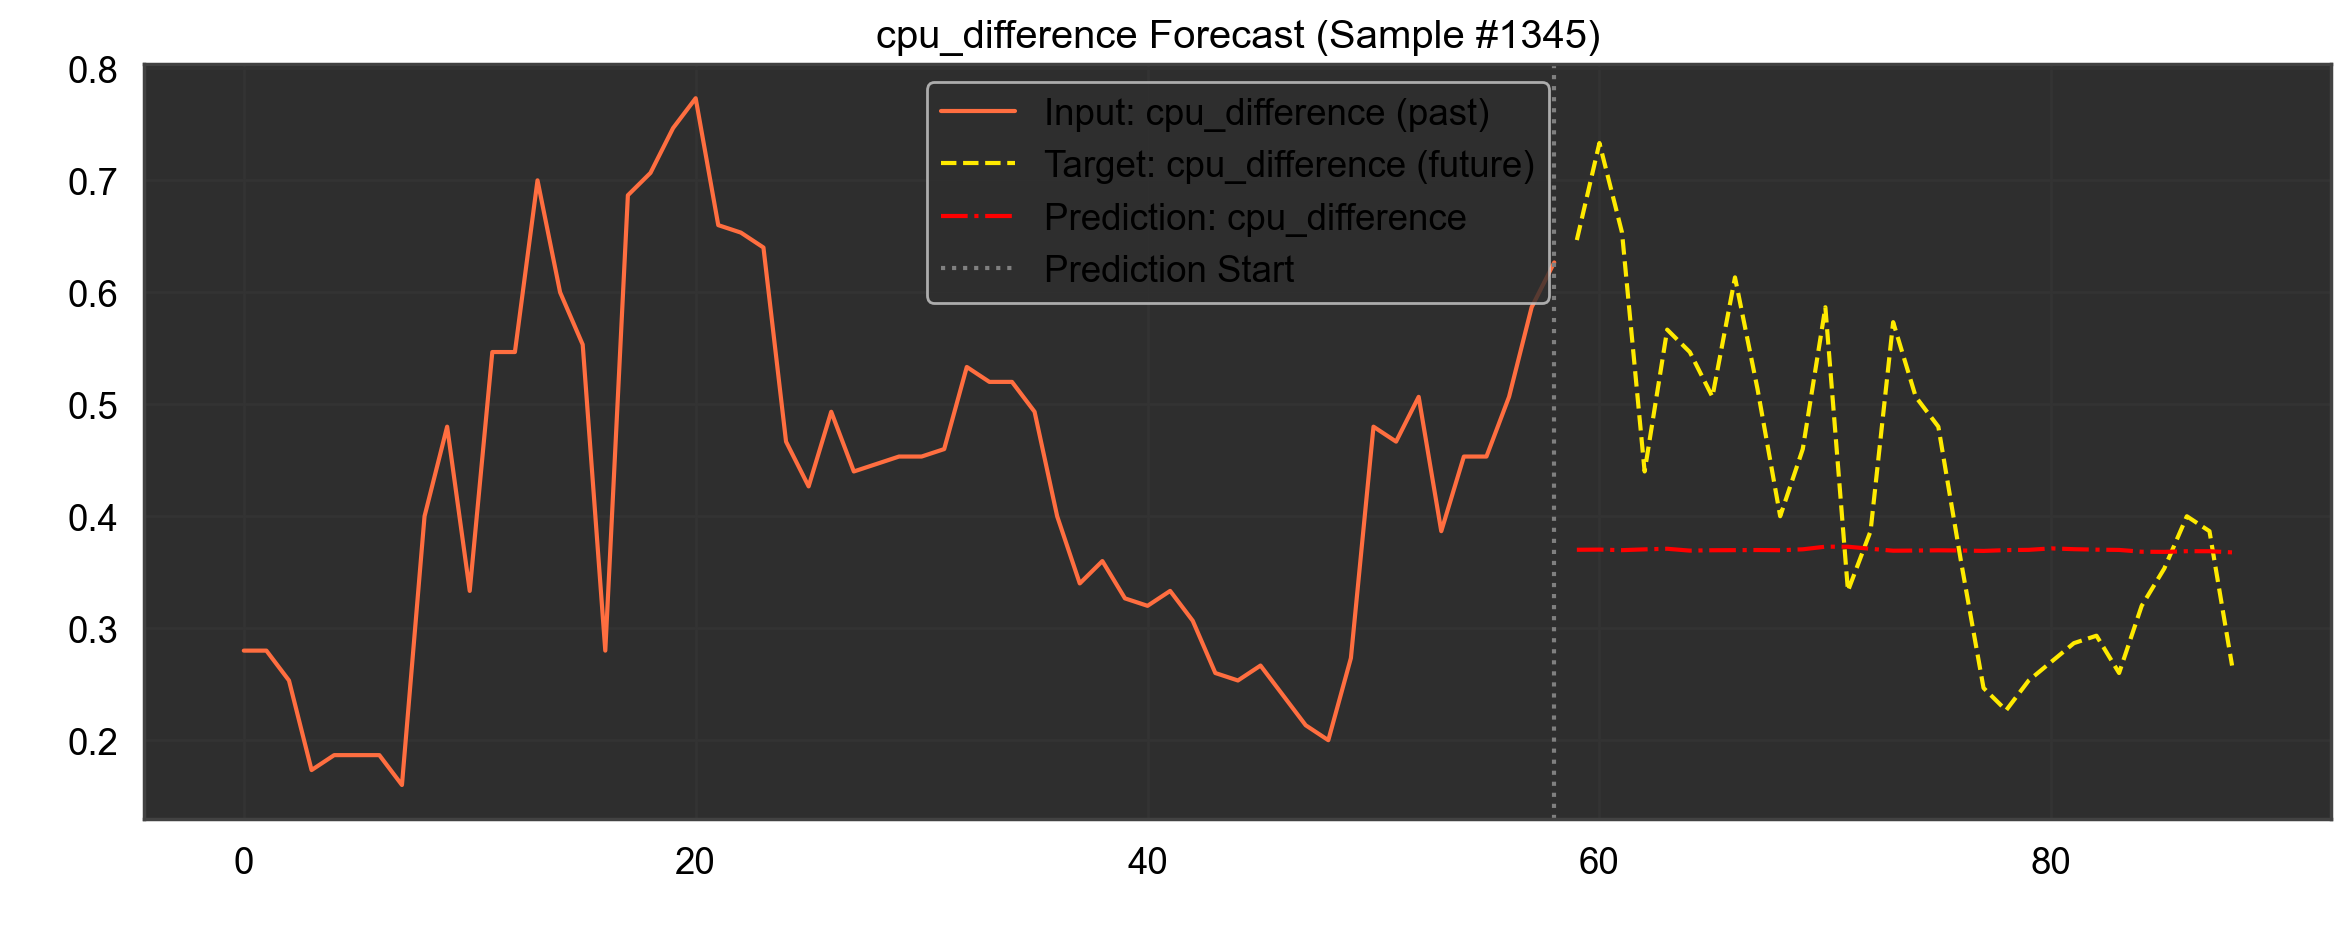

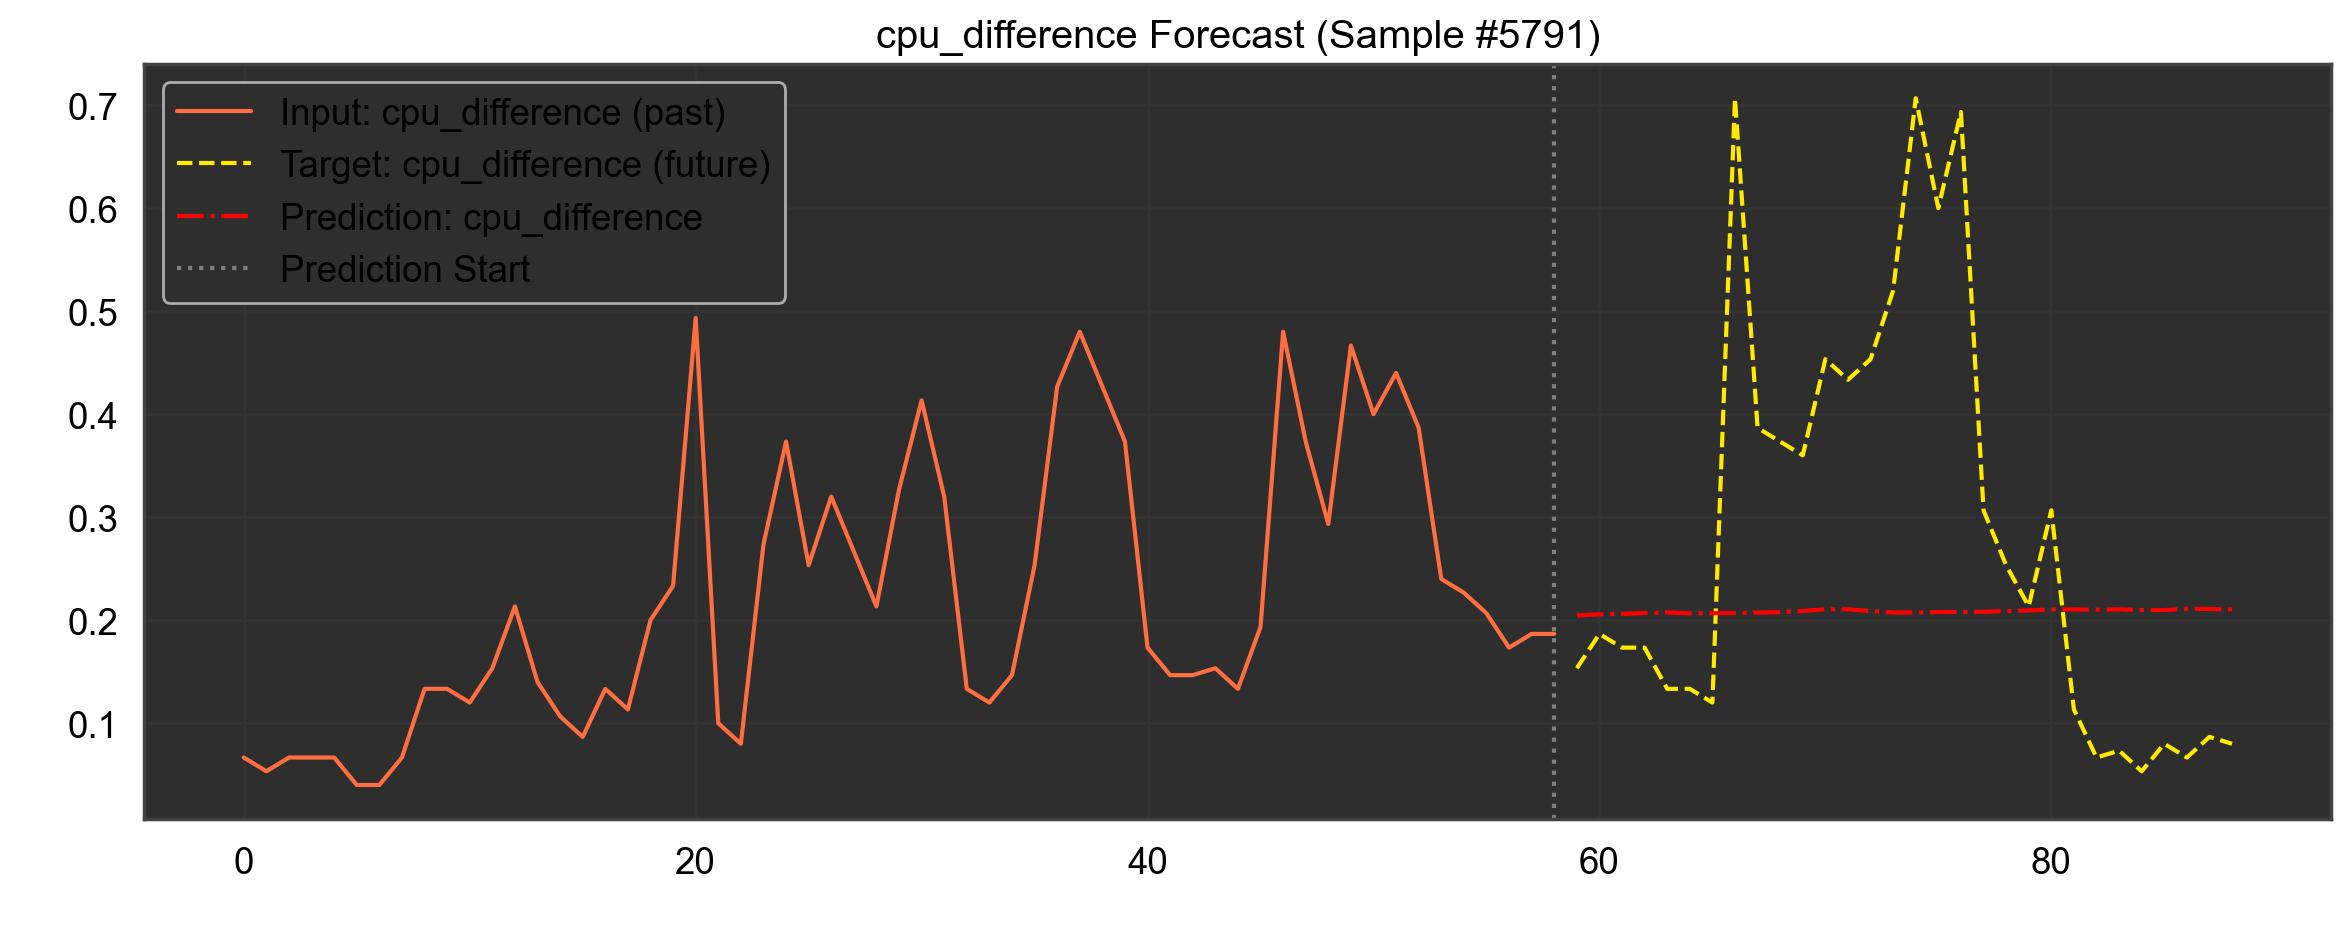

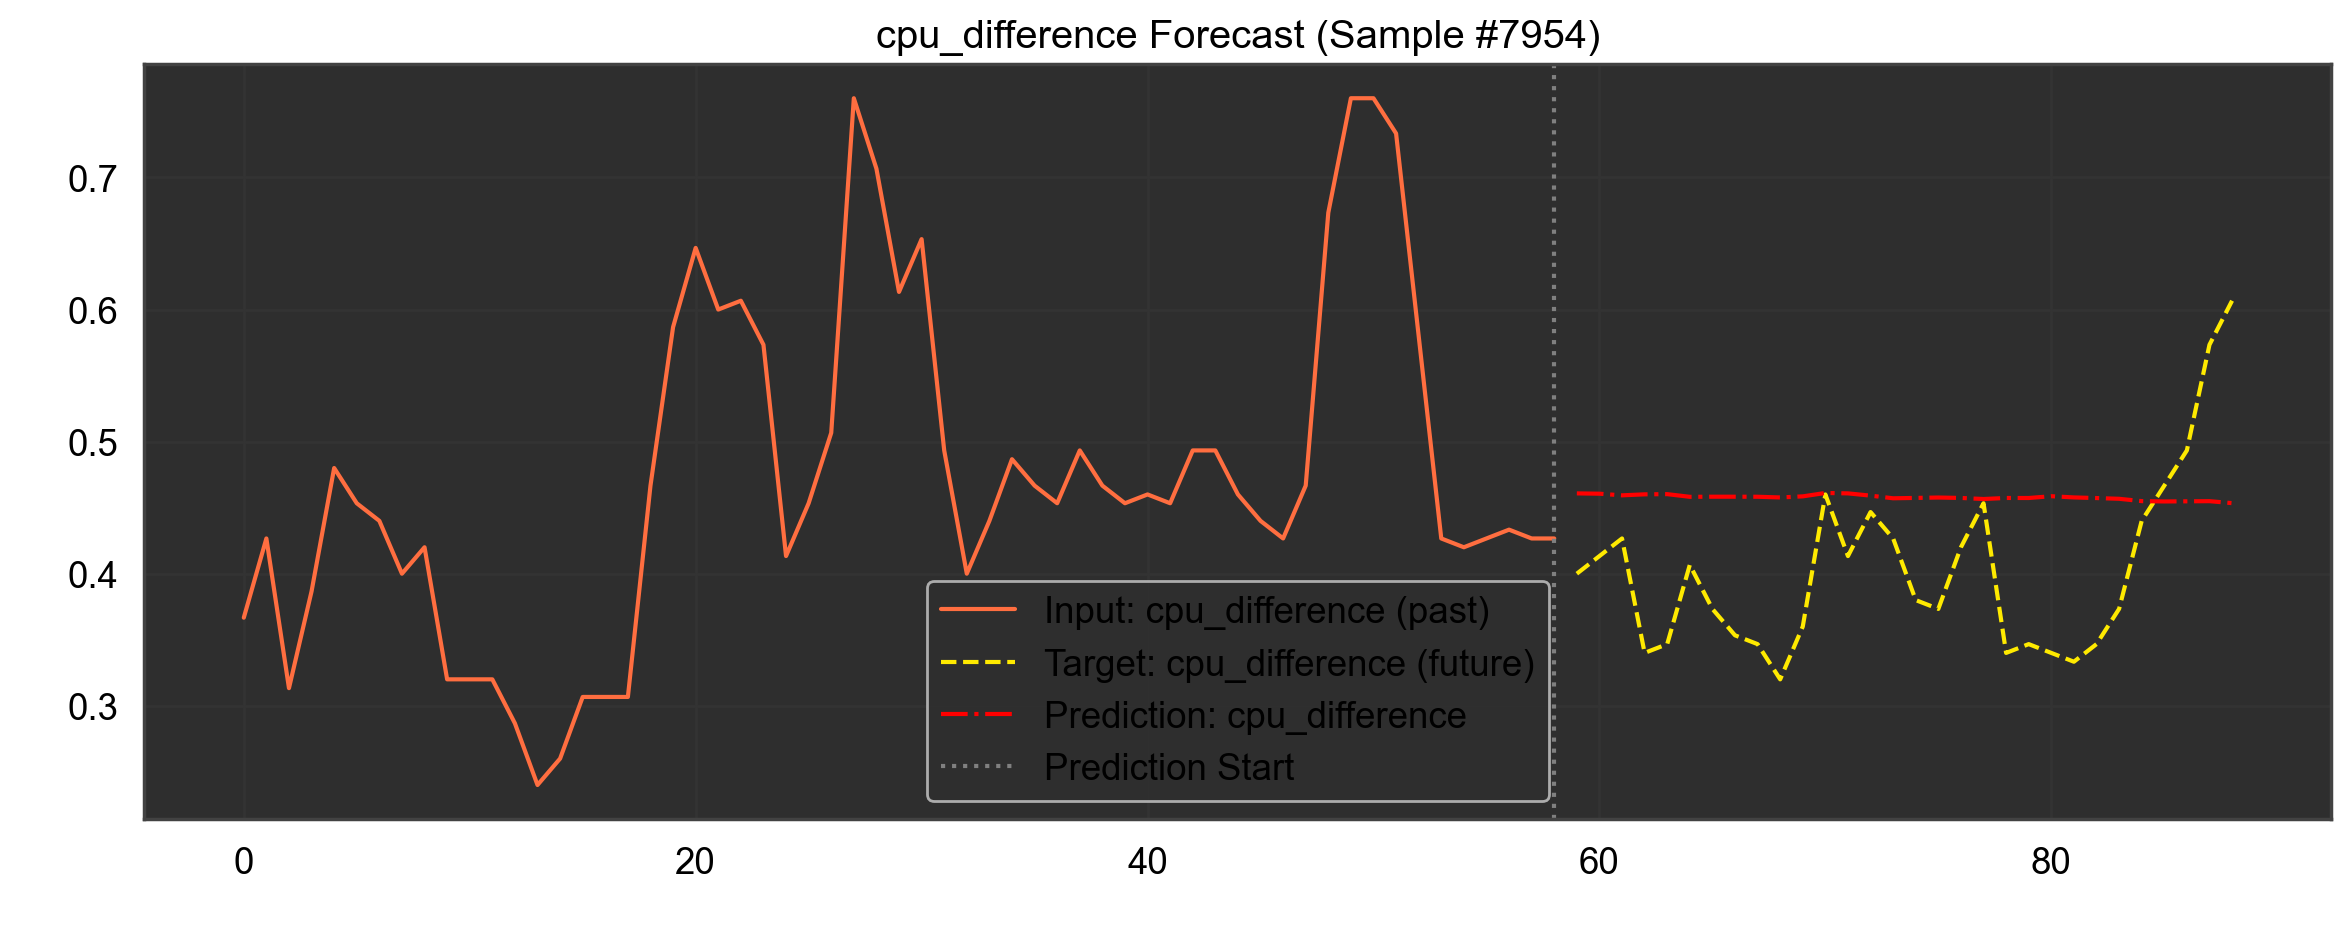

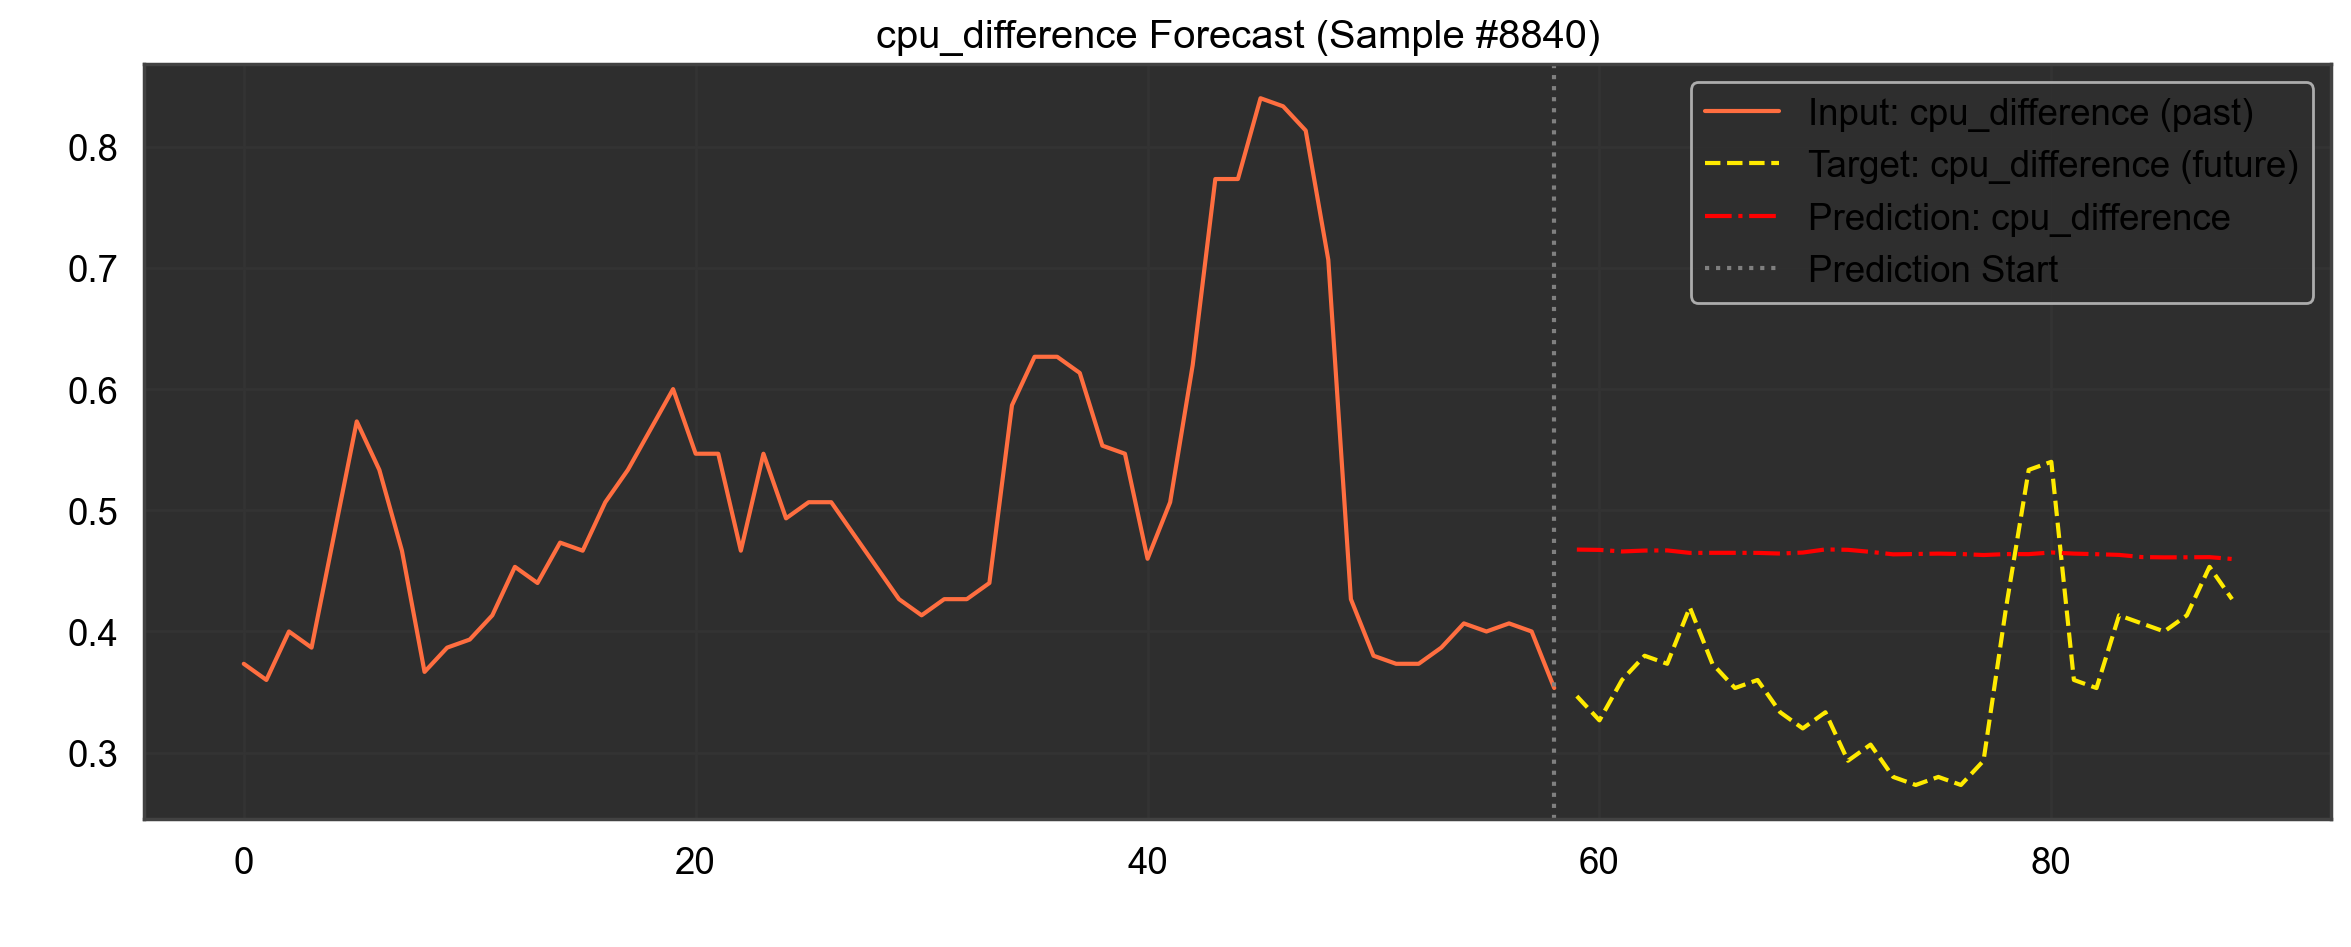

In [ ]:
import random 
for _ in range(10):
    visualize_target_sequence(X_test, y_test, predictions, sample_idx=random.randint(0,10000))